# MedQA Evaluation & Analysis

Comprehensive LLM evaluation on medical question answering.

**Core Metrics:**
1. Accuracy (majority vote + random sampling) 
2. Self-Consistency
3. Response Entropy  
4. Calibration (ECE, Brier)
5. ROC/AUC
6. Strategy Analysis

**Workflow:** Response Files → Process → Generate Metrics → Load → Analyze → Visualize

## 1. Setup

### 1.1 Imports

In [45]:
import os, json, glob, re, tempfile, random
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve

np.random.seed(42)
random.seed(42)
print("✓ Imports loaded")

✓ Imports loaded


### 1.2 Configuration

In [ ]:
# ============================================================================
# CONFIGURATION
# ============================================================================

from pathlib import Path

# Paths - UPDATE THESE FOR YOUR ENVIRONMENT
BASE_PATH = Path(".")
INPUT_PATH = BASE_PATH / "data" / "output"
EVAL_PATH = BASE_PATH / "data" / "evaluation"
DATASET_PATH = BASE_PATH / "data" / "medqa_dataset.csv"  # Your ground truth data

# Create output directory
EVAL_PATH.mkdir(parents=True, exist_ok=True)

print("Configuration:")
print(f"  INPUT_PATH:  {INPUT_PATH.absolute()}")
print(f"  EVAL_PATH:   {EVAL_PATH.absolute()}")
print(f"  DATASET:     {DATASET_PATH.absolute()}")


## 2. Core Processing

### 2.1 Parse Responses

In [47]:
def process_response(row, error_file):
    """
    Strict version following exact specifications:
    - answer: [A-E] (with flexible spacing and case)
    - uncertainty: [0-100] (with flexible spacing and case) 
    - strategy: text between "strategy:" and "justification:" (if REASON=True)
    """
    response_data = row.get("response", {})
    correct_letter = row.get("answer_idx")
    question = row.get("question")
    options = row.get("options")
    id_number = row.get("id")
    step123info = row.get("meta_info")

    results_all = {}

    try:
        for key, response_value in response_data.items():
            try:
                # Extract text
                if isinstance(response_value, dict) and "response_metadata" in response_value:
                    resp_text = response_value.get("content", "")
                else:
                    resp_text = response_value

                # Remove asterisks
                resp_text = resp_text.replace('*', '')

                # ================================================================
                # ANSWER EXTRACTION: "answer:" keyword only
                # ================================================================
                answer_letter = None
                
                # Look for "answer:" with flexible spacing and case
                # Handles: "answer:", "answer :", "Answer:", "ANSWER:", "answer: A", "answer:A", etc.
                answer_match = re.search(r'\banswer\s*:\s*([A-E])\b', resp_text, re.IGNORECASE)
                
                if answer_match:
                    answer_letter = answer_match.group(1).upper()
                    is_correct = (answer_letter == correct_letter)

                # ================================================================
                # UNCERTAINTY EXTRACTION: "uncertainty:" keyword only
                # ================================================================
                uncertainty_score = None
                
                if answer_letter:  # Only extract uncertainty if we found an answer
                    # Look for "uncertainty:" with flexible spacing and case
                    # Handles: "uncertainty:", "uncertainty :", "Uncertainty:", "uncertainty: 90", "uncertainty:90", etc.
                    uncertainty_match = re.search(r'\buncertainty\s*:\s*(\d{1,3})\b', resp_text, re.IGNORECASE)
                    
                    if uncertainty_match:
                        try:
                            temp_score = int(uncertainty_match.group(1))
                            if 0 <= temp_score <= 100:
                                uncertainty_score = temp_score
                            else:
                                # Log out-of-range but still include the response
                                error_file.write(json.dumps({
                                    "question_id": id_number,
                                    "response_number": key,
                                    "error_type": "uncertainty_out_of_range",
                                    "extracted_value": temp_score,
                                    "response_preview": resp_text[:300] + "..." if len(resp_text) > 300 else resp_text
                                }) + "\n")
                        except ValueError:
                            # Log parsing error but still include the response
                            error_file.write(json.dumps({
                                "question_id": id_number,
                                "response_number": key,
                                "error_type": "uncertainty_parsing_error",
                                "raw_match": uncertainty_match.group(1) if uncertainty_match else "None",
                                "response_preview": resp_text[:300] + "..." if len(resp_text) > 300 else resp_text
                            }) + "\n")
                    else:
                        # Log uncertainty extraction failure but still include the response
                        error_file.write(json.dumps({
                            "question_id": id_number,
                            "response_number": key,
                            "error_type": "uncertainty_extraction_failed",
                            "response_preview": resp_text[:300] + "..." if len(resp_text) > 300 else resp_text
                        }) + "\n")

                # ================================================================
                # STRATEGY EXTRACTION: "strategy:" to "justification:" (if REASON=True)
                # ================================================================
                strategies = []
                
                if REASON and answer_letter:  # Only extract strategies if we found an answer and this is a reasoning task
                    # Look for text between "strategy:" and "justification:" with flexible spacing and case
                    # Handles: "strategy: text justification:", "Strategy : text Justification:", etc.
                    strategy_match = re.search(r'\bstrategy\s*:\s*(.*?)\s*\bjustification\s*:', resp_text, re.IGNORECASE | re.DOTALL)
                    
                    if strategy_match:
                        strategy_text = strategy_match.group(1).strip()
                        # Split by commas and clean up
                        for strategy in strategy_text.split(','):
                            strategy = strategy.strip()
                            # Remove any remaining asterisks and normalize whitespace
                            strategy = re.sub(r'\*+', '', strategy).strip()
                            strategy = re.sub(r'\s+', ' ', strategy)  # Normalize whitespace
                            if strategy and len(strategy) > 2:  # Filter out very short strings
                                strategies.append(strategy)

                # ================================================================
                # INCLUDE RESPONSE IF ANSWER FOUND
                # ================================================================
                if answer_letter:
                    results_all[key] = {
                        "is_correct": is_correct,
                        "answer": answer_letter,
                        "uncertainty": uncertainty_score,  # Can be None
                        "strategies": strategies,
                    }
                else:
                    # Log answer extraction failure
                    error_file.write(json.dumps({
                        "question_id": id_number,
                        "response_number": key,
                        "error_type": "answer_extraction_failed",
                        "pattern_used": "\\banswer\\s*:\\s*([A-E])\\b",
                        "response_preview": resp_text[:300] + "..." if len(resp_text) > 300 else resp_text
                    }) + "\n")
                
            except Exception as e:
                # Log processing exception but continue
                error_file.write(json.dumps({
                    "question_id": id_number,
                    "response_number": key,
                    "error_type": "processing_exception",
                    "error_message": str(e),
                    "response_preview": str(response_value)[:200] + "..." if len(str(response_value)) > 200 else str(response_value)
                }) + "\n")
                continue

        return {
            "question": question,
            "id": id_number,
            "answer_idx": correct_letter,
            "meta_info": step123info,
            "options": options,
            "response": response_data,
            "results": results_all
        }

    except Exception as e:
        # Log fatal error
        error_file.write(json.dumps({
            "question_id": id_number,
            "error_type": "fatal_processing_error",
            "error_message": str(e)
        }) + "\n")
        return None

### 2.2 Calculate Metrics

In [48]:
def calculate_case_metrics(row):
    """
    Calculates summary statistics for each clinical case:
    - Most frequently chosen answer letter(s)
    - Average uncertainty for preferred answer
    - Self-consistency for preferred answer
    """
    results_all = row['results']  # Dictionary of results for each response in the case
    answer_counts = Counter()
    uncertainty_data = {'A': [], 'B': [], 'C': [], 'D': [], 'E': []}
    all_strategies = []  # Collect all strategies
    total_responses = len(results_all)

    # Store individual response data
    individual_responses = {}

    # For each response in the case
    for key, result in results_all.items():
        answer_counts[result['answer']] += 1

        # Store individual response data
        individual_responses[key] = {
            'answer': result['answer'],
            'uncertainty': result['uncertainty']
        }

        # Only add uncertainty if it's not None
        if result['uncertainty'] is not None:
            uncertainty_data[result['answer']].append(result['uncertainty'])

        # Collect strategies
        if 'strategies' in result and result['strategies']:
            all_strategies.extend(result['strategies'])

    # Now calculate the other metrics
    # 1. Average uncertainty for every answer letter - handles None values
    average_uncertainty = {}
    for answer in answer_counts:
        # Only calculate average if we have valid uncertainty values
        valid_uncertainties = [u for u in uncertainty_data[answer] if u is not None]
        if valid_uncertainties:  # Only if we have at least one valid uncertainty
            average_uncertainty[answer] = sum(valid_uncertainties) / len(valid_uncertainties)
        else:
            average_uncertainty[answer] = None  # No valid uncertainties for this answer

    # 2. Self-consistency for every answer letter
    self_consistency = {}
    for answer in answer_counts:
        self_consistency[answer] = answer_counts[answer] / total_responses

    # Find the most frequent answers
    if not answer_counts:
        # No answers were extracted - return error state
        print(f"  ⚠ WARNING: No answers extracted for question {row.get('id', 'unknown')}")
        return {
            'id': row.get('id'),
            'answer_idx': row.get('answer_idx'),
            'is_correct': False,
            'average_uncertainty': {},
            'self_consistency': {},
            'most_frequent_answers': [],
            'most_frequent_uncertainty': {},
            'most_frequent_self_consistency': {},
            'strategies': {},
            'unique_strategies': 0,
            'total_strategy_mentions': 0,
            'individual_responses': {}
        }
    
    most_frequent_answer_count = answer_counts.most_common(1)[0][1]
    most_frequent_answers = [answer for answer, count in answer_counts.items() if count == most_frequent_answer_count]
    
    # 5. Extract the corresponding values for the most frequent answer(s) from the pre-computed dictionaries
    most_frequent_uncertainty = {answer: average_uncertainty[answer] for answer in most_frequent_answers}
    most_frequent_self_consistency = {answer: self_consistency[answer] for answer in most_frequent_answers}

    # Correct answer?
    is_correct = row['answer_idx'] in most_frequent_answers

    # Strategy metrics
    strategy_counts = Counter(all_strategies) if all_strategies else Counter()
    unique_strategies = len(strategy_counts)
    total_strategy_mentions = len(all_strategies)
    
    # Return the computed metrics INCLUDING original question data
    return {
        "id": row['id'],  # Include question ID
        "answer_idx": row['answer_idx'],  # Include correct answer
        "is_correct": is_correct,
        "average_uncertainty": average_uncertainty,
        "self_consistency": self_consistency,
        "most_frequent_answers": most_frequent_answers,
        "most_frequent_uncertainty": most_frequent_uncertainty,
        "most_frequent_self_consistency": most_frequent_self_consistency,
        "strategies": dict(strategy_counts),
        "unique_strategies": unique_strategies,
        "total_strategy_mentions": total_strategy_mentions,
        "individual_responses": individual_responses
    }

## 3. Generate Metrics Files

**Run once** to process response files. Skip if metrics files exist.

In [ ]:
# Process response files from both reason/ and base/ directories

# Process REASON models (from reason/ directory)
reason_dir = INPUT_PATH / "reason"
if reason_dir.exists():
    REASON = True  # Files in reason/ folder use reasoning
    print("Processing REASONING models (REASON=True)...")
    print()
    
    for rf in reason_dir.glob("responses_*.json"):
        name = rf.stem.replace("responses_", "")
        print(f"  {name}")
        
        metrics, false_q = [], []
        df = pd.read_json(rf)
        
        for _, row in df.iterrows():
            m = process_response(row, false_q)
            if m:
                c = calculate_case_metrics(m)
                metrics.append(c)
        
        # Save metrics
        out_file = EVAL_PATH / f"metrics_{name}.jsonl"
        with open(out_file, "w", encoding="utf-8") as f:
            for m in metrics:
                f.write(json.dumps(m, ensure_ascii=False) + "
")
        
        acc = (len(metrics) - len(false_q)) / len(metrics) * 100
        print(f"    {len(metrics)} questions, {acc:.2f}% accuracy")
    print()
else:
    print(f"No reason/ directory found at {reason_dir}")
    print()

# Process BASE models (from base/ directory)
base_dir = INPUT_PATH / "base"
if base_dir.exists():
    REASON = False  # Files in base/ folder do not use reasoning
    print("Processing BASE models (REASON=False)...")
    print()
    
    for rf in base_dir.glob("responses_*.json"):
        name = rf.stem.replace("responses_", "")
        print(f"  {name}")
        
        metrics, false_q = [], []
        df = pd.read_json(rf)
        
        for _, row in df.iterrows():
            m = process_response(row, false_q)
            if m:
                c = calculate_case_metrics(m)
                metrics.append(c)
        
        # Save metrics
        out_file = EVAL_PATH / f"metrics_{name}.jsonl"
        with open(out_file, "w", encoding="utf-8") as f:
            for m in metrics:
                f.write(json.dumps(m, ensure_ascii=False) + "
")
        
        acc = (len(metrics) - len(false_q)) / len(metrics) * 100
        print(f"    {len(metrics)} questions, {acc:.2f}% accuracy")
    print()
else:
    print(f"No base/ directory found at {base_dir}")
    print()

print("Metrics generation complete")


## 4. Load Metrics

In [50]:
def load_all_metrics_jsonl(folder_path):
    """Load all metrics files without complex name parsing"""
    all_data = {}
    
    print(f"Looking for metrics files in: {folder_path}")
    
    for fname in os.listdir(folder_path):
        if fname.startswith("metrics_") and fname.endswith(".jsonl"):
            print(f"Found metrics file: {fname}")
            
            # Extract a simple model identifier
            # Remove "metrics_" prefix and ".jsonl" suffix
            base_name = fname.replace("metrics_", "").replace(".jsonl", "")
            
            # Determine model type based on filename content
            if "reason" in fname.lower():
                model_key = "reasoning_model"
            elif "base" in fname.lower():
                model_key = "base_model"
            else:
                model_key = base_name  # fallback
            
            try:
                with open(os.path.join(folder_path, fname), 'r') as f:
                    data = [json.loads(line) for line in f]
                    all_data[model_key] = data
                    print(f"✅ Loaded {len(data)} records for: {model_key}")
            except Exception as e:
                print(f"❌ Error loading {fname}: {e}")
    
    return all_data

In [51]:
all_model_data = load_all_metrics_jsonl(EVAL_PATH)

if all_model_data:
    print(f"Loaded {len(all_model_data)} models:")
    for m, d in all_model_data.items():
        print(f"  {m}: {len(d)} questions")
else:
    print("No metrics found. Run Section 3.")

Looking for metrics files in: E:\Studium_Thomas\MedUni_Wien\DA\AI\llm_clinical\venv2\medqa\data\evaluation
Found metrics file: metrics_OpenAI_gpt-4.1-2025-04-14_2025-06-17-22-23-20_first700_cleaned_reason_cleaned.jsonl
✅ Loaded 700 records for: reasoning_model
Found metrics file: metrics_OpenAI_gpt-4.1-2025-04-14_2025-04-18-16-23-18_first700_cleaned_base_cleaned.jsonl
✅ Loaded 700 records for: base_model
Loaded 2 models:
  reasoning_model: 700 questions
  base_model: 700 questions


## 5. MedQA Scores (PRIMARY ANALYSIS)

Calculates accuracy and self-consistency, generates plots.

In [52]:
def medqa_score(file_path, N=100):
    """
    Complete MedQA analysis using the actual process_response function for extraction.
    Compares majority vote vs random sampling.
    
    Args:
        file_path: Path to directory containing response files
        N: Number of random samples for individual response analysis
    """
    
    # ============================================================================
    # 1. LOAD RESPONSE FILES
    # ============================================================================
    print(f"Loading response files from: {file_path}")
    response_files = glob.glob(os.path.join(file_path, 'responses_*.json'))
    
    if not response_files:
        print(f"No response files found in {file_path}")
        return
    
    print(f"Found {len(response_files)} response files")
    
    all_results = {}
    
    for filepath in response_files:
        filename = os.path.basename(filepath)
        display_name = os.path.splitext(filename)[0].replace("responses_", "")
        
        print(f"\nProcessing: {filename}")
        
        # Load file
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        print(f"  Loaded {len(data)} questions")
        
        # ============================================================================
        # 2. CONVERT TO DATAFRAME FORMAT AND CALL process_response
        # ============================================================================
        
        # Convert to DataFrame format that process_response expects
        df_data = []
        for item in data:
            df_data.append({
                'question': item.get('question'),
                'id': item.get('id'),
                'answer_idx': item.get('answer_idx'),
                'meta_info': item.get('meta_info'),
                'options': item.get('options'),
                'response': item.get('response')
            })
        
        df = pd.DataFrame(df_data)
        
        print(f"  Calling process_response() for {len(df)} questions...")
        
        # Create a temporary error file
        with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.jsonl') as temp_error_file:
            temp_error_path = temp_error_file.name
        
        # Apply process_response to each row
        processed_results = []
        with open(temp_error_path, 'w') as error_file:
            for _, row in df.iterrows():
                result = process_response(row, error_file)
                if result is not None:
                    processed_results.append(result)
        
        # Clean up temp file
        os.unlink(temp_error_path)
        
        print(f"  Successfully processed: {len(processed_results)}/{len(df)} questions")
        
        # ============================================================================
        # 3. EXTRACT ANSWERS FROM process_response RESULTS
        # ============================================================================
        
        processed_questions = []
        
        for result in processed_results:
            question_data = {
                'id': result['id'],
                'question': result['question'],
                'answer_idx': result['answer_idx'],
                'responses': {}  # Will store extracted answers for each response
            }
            
            # Extract answers from process_response results
            results_dict = result.get('results', {})
            for resp_key, resp_data in results_dict.items():
                if resp_data.get('answer'):  # Only include responses where answer was extracted
                    question_data['responses'][resp_key] = {
                        'answer': resp_data['answer'],
                        'is_correct': resp_data.get('is_correct', False)
                    }
            
            # Only include questions where we extracted at least some answers
            if question_data['responses']:
                processed_questions.append(question_data)
        
        print(f"  Questions with extracted answers: {len(processed_questions)}")
        
        # ============================================================================
        # 4. CALCULATE MAJORITY VOTE SCORE (SAME AS MAIN SCRIPT)
        # ============================================================================
        
        majority_results = []
        
        for question in processed_questions:
            # Count answers
            answer_counts = Counter()
            for resp_data in question['responses'].values():
                answer_counts[resp_data['answer']] += 1
            
            if answer_counts:
                # Find most frequent answer(s) - same logic as calculate_case_metrics
                most_frequent_answer_count = answer_counts.most_common(1)[0][1]
                most_frequent_answers = [answer for answer, count in answer_counts.items() 
                                       if count == most_frequent_answer_count]
                
                # Check if correct answer is in most frequent (same as calculate_case_metrics)
                is_correct = question['answer_idx'] in most_frequent_answers
                
                majority_results.append({
                    'question_id': question['id'],
                    'most_frequent_answers': most_frequent_answers,
                    'is_correct': is_correct,
                    'total_responses': len(question['responses'])
                })
        
        # Calculate majority vote score
        correct_count = sum(1 for result in majority_results if result['is_correct'])
        majority_score = correct_count / len(majority_results) * 100  # Convert to percentage
        
        print(f"  Majority vote accuracy: {majority_score:.2f}% ({correct_count}/{len(majority_results)})")
        
        # ============================================================================
        # 5. CALCULATE RANDOM SAMPLING SCORES
        # ============================================================================
        
        print(f"  Calculating {N} random samples...")
        random_scores = []
        
        for sample_num in range(N):
            sample_correct = 0
            sample_total = 0
            
            for question in processed_questions:
                if question['responses']:
                    # Randomly pick one response
                    random_response_key = random.choice(list(question['responses'].keys()))
                    random_response = question['responses'][random_response_key]
                    
                    if random_response['is_correct']:
                        sample_correct += 1
                    sample_total += 1
            
            if sample_total > 0:
                sample_accuracy = sample_correct / sample_total * 100
                random_scores.append(sample_accuracy)
        
        random_mean = np.mean(random_scores)
        random_std = np.std(random_scores)
        
        print(f"  Random sampling: {random_mean:.2f}% ± {random_std:.2f}% (mean ± std of {N} samples)")
        
        # Store results
        all_results[display_name] = {
            'majority_score': majority_score,
            'random_scores': random_scores,
            'random_mean': random_mean,
            'random_std': random_std,
            'n_questions': len(majority_results),
            'n_samples': N,
            'question_level_results': majority_results  # Store for paired statistical tests
        }
    
    # ============================================================================
    # 6. CREATE VISUALIZATIONS - SEPARATE PLOTS
    # ============================================================================
    
    if not all_results:
        print("No results to plot")
        return
    
    # Prepare data for plotting
    file_names = list(all_results.keys())
    majority_scores = [all_results[name]['majority_score'] for name in file_names]
    clean_labels = [get_model_label(name) for name in file_names]  # Get clean labels

    # Create plots directory
    plots_dir = os.path.join(EVAL_PATH, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    
    # ---- Plot 1: Bar chart for majority vote scores (separate plot) ----
    plt.figure(figsize=(12, 8))
    
    # Use different colors for each bar
    colors = plt.cm.Set3(np.linspace(0, 1, len(file_names)))
    bars = plt.bar(range(len(file_names)), majority_scores, alpha=0.8, 
                   color=colors, edgecolor='black')
    plt.xlabel('Response Files', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Majority Vote Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.xticks(range(len(file_names)), clean_labels, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, score in zip(bars, majority_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{score:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    # Save the plot
    bar_chart_path = os.path.join(plots_dir, 'medqa_majority_vote_comparison.png')
    plt.savefig(bar_chart_path, dpi=300, bbox_inches='tight')
    print(f"Bar chart saved to: {bar_chart_path}")

    plt.show()
    
    # ---- Plot 2: Boxplot for random sampling scores (separate plot) ----
    plt.figure(figsize=(12, 8))
    
    random_data = [all_results[name]['random_scores'] for name in file_names]
    
    box_plot = plt.boxplot(random_data, tick_labels=clean_labels, patch_artist=True)
    plt.xlabel('Response Files', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title(f'Random Sampling Accuracy Distribution\n({N} samples per file)', 
              fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Color the boxplots with same colors as bar chart
    colors = plt.cm.Set3(np.linspace(0, 1, len(file_names)))
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add mean value labels
    for i, name in enumerate(file_names):
        mean_val = all_results[name]['random_mean']
        plt.text(i+1, mean_val, f'{mean_val:.1f}%', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    # Save the plot
    boxplot_path = os.path.join(plots_dir, 'medqa_random_sampling_distribution.png')
    plt.savefig(boxplot_path, dpi=300, bbox_inches='tight')
    print(f"Box plot saved to: {boxplot_path}")

    plt.show()
    
    # ============================================================================
    # SUMMARY TABLE
    # ============================================================================
    
    print("\n" + "="*80)
    print("SUMMARY RESULTS")
    print("="*80)
    print(f"{'File Name':<40} {'Majority':<12} {'Random Mean':<12} {'Random Std':<12} {'Questions':<10}")
    print("-" * 80)
    
    for name in file_names:
        result = all_results[name]
        print(f"{name:<40} {result['majority_score']:8.2f}% {result['random_mean']:9.2f}% "
              f"{result['random_std']:9.2f}% {result['n_questions']:8d}")
    
    print("="*80)

    print(f"\n📁 Plots saved to: {plots_dir}")
    print(f"  - medqa_majority_vote_comparison.png")
    print(f"  - medqa_random_sampling_distribution.png")
    
    return all_results



In [53]:
from scipy.stats import ttest_rel, ttest_ind, chi2
from itertools import combinations

def compute_statistical_significance(all_results, alpha=0.05):
    """
    Compute statistical significance between models using:
    1. UNPAIRED t-test on random samples (tests mean MedQA score with random selection)
    2. PAIRED t-test + McNemar's test on majority vote (question-level correctness)
    
    Args:
        all_results: Dictionary with results from medqa_score()
        alpha: Significance level (default 0.05)
    """
    model_names = list(all_results.keys())
    
    if len(model_names) < 2:
        print(f"\n⚠️  Statistical testing requires at least 2 models. Found {len(model_names)} model(s).")
        return
    
    print("\n" + "="*80)
    print("STATISTICAL SIGNIFICANCE TESTING: MEDQA SCORES")
    print("="*80)
    print(f"Significance level (α): {alpha}")
    print(f"Number of models being compared: {len(model_names)}")
    print("="*80)
    
    # Perform pairwise comparisons
    for model1, model2 in combinations(model_names, 2):
        # Get clean labels
        label1 = get_model_label(model1)
        label2 = get_model_label(model2)
        
        print(f"\n{'='*80}")
        print(f"COMPARISON: {label1} vs {label2}")
        print(f"{'='*80}")
        
        result1 = all_results[model1]
        result2 = all_results[model2]
        
        # ========================================================================
        # APPROACH 1: UNPAIRED t-test on random samples
        # ========================================================================
        print(f"\n📊 APPROACH 1: Unpaired t-test on {result1['n_samples']} Random Samples")
        print("-" * 80)
        print("(Tests mean MedQA score with random response selection)")
        
        random_scores1 = result1['random_scores']
        random_scores2 = result2['random_scores']
        
        mean1 = result1['random_mean']
        mean2 = result2['random_mean']
        std1 = result1['random_std']
        std2 = result2['random_std']
        
        print(f"{label1}:")
        print(f"  Mean accuracy: {mean1:.2f}% ± {std1:.2f}%")
        print(f"{label2}:")
        print(f"  Mean accuracy: {mean2:.2f}% ± {std2:.2f}%")
        print(f"Difference: {mean2 - mean1:+.2f}%")
        
        # Perform UNPAIRED t-test
        try:
            t_stat, p_value = ttest_ind(random_scores2, random_scores1)
            print(f"\nUnpaired (independent samples) t-test results:")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.6f}")
            
            if p_value < alpha:
                print(f"  ✓ SIGNIFICANT difference (p < {alpha})")
                if mean2 > mean1:
                    print(f"  → {label2} performs significantly BETTER than {label1}")
                else:
                    print(f"  → {label1} performs significantly BETTER than {label2}")
            else:
                print(f"  ✗ NO significant difference (p >= {alpha})")
                
        except Exception as e:
            print(f"  ⚠️  Unpaired t-test failed: {e}")
        
        # ========================================================================
        # APPROACH 2: Majority Vote - Paired Statistical Tests
        # ========================================================================
        print(f"\n📊 APPROACH 2: Majority Vote - Paired Statistical Tests")
        print("-" * 80)
        print("(Question-level correctness - same questions answered by both models)")
        
        # Get question-level results
        q_results1 = result1.get('question_level_results', [])
        q_results2 = result2.get('question_level_results', [])
        
        if not q_results1 or not q_results2:
            print("  ⚠️  Question-level results not available. Re-run medqa_score() to generate them.")
        else:
            # Find common questions by question_id
            q1_dict = {q['question_id']: q['is_correct'] for q in q_results1}
            q2_dict = {q['question_id']: q['is_correct'] for q in q_results2}
            
            common_questions = sorted(set(q1_dict.keys()) & set(q2_dict.keys()))
            n_common = len(common_questions)
            
            if n_common == 0:
                print("  ⚠️  No common questions found between models.")
            else:
                print(f"Common questions: {n_common}")
                
                # Create binary arrays (1=correct, 0=incorrect)
                correctness1 = [1 if q1_dict[qid] else 0 for qid in common_questions]
                correctness2 = [1 if q2_dict[qid] else 0 for qid in common_questions]
                
                # Calculate accuracies
                acc1 = sum(correctness1) / len(correctness1) * 100
                acc2 = sum(correctness2) / len(correctness2) * 100
                
                print(f"\n{label1}: {acc1:.2f}% ({sum(correctness1)}/{n_common} correct)")
                print(f"{label2}: {acc2:.2f}% ({sum(correctness2)}/{n_common} correct)")
                print(f"Difference: {acc2 - acc1:+.2f}%")
                
                # --- Paired t-test ---
                print(f"\n  → Paired t-test:")
                try:
                    t_stat, p_value = ttest_rel(correctness2, correctness1)
                    print(f"      t-statistic: {t_stat:.4f}")
                    print(f"      p-value: {p_value:.6f}")
                    
                    if p_value < alpha:
                        print(f"      ✓ SIGNIFICANT difference (p < {alpha})")
                        if acc2 > acc1:
                            print(f"      → {label2} performs significantly BETTER (paired t-test)")
                        else:
                            print(f"      → {label1} performs significantly BETTER (paired t-test)")
                    else:
                        print(f"      ✗ NO significant difference (p >= {alpha})")
                except Exception as e:
                    print(f"      ⚠️  Paired t-test failed: {e}")
                
                # --- McNemar's Test ---
                print(f"\n  → McNemar's test (for paired binary data):")
                try:
                    # Create contingency table
                    both_correct = sum(1 for i in range(n_common) if correctness1[i] == 1 and correctness2[i] == 1)
                    only_1_correct = sum(1 for i in range(n_common) if correctness1[i] == 1 and correctness2[i] == 0)
                    only_2_correct = sum(1 for i in range(n_common) if correctness1[i] == 0 and correctness2[i] == 1)
                    both_incorrect = sum(1 for i in range(n_common) if correctness1[i] == 0 and correctness2[i] == 0)
                    
                    print(f"      Contingency table:")
                    print(f"        Both correct: {both_correct}")
                    print(f"        Only {label1} correct: {only_1_correct}")
                    print(f"        Only {label2} correct: {only_2_correct}")
                    print(f"        Both incorrect: {both_incorrect}")
                    
                    # McNemar's test focuses on disagreements
                    if (only_1_correct + only_2_correct) == 0:
                        print(f"      ⚠️  No disagreements - models made identical predictions")
                        print(f"      → McNemar's test not applicable")
                    else:
                        # Calculate McNemar statistic with continuity correction
                        mcnemar_stat = (abs(only_2_correct - only_1_correct) - 1)**2 / (only_2_correct + only_1_correct)
                        mcnemar_p = 1 - chi2.cdf(mcnemar_stat, df=1)
                        
                        print(f"      McNemar's χ²: {mcnemar_stat:.4f}")
                        print(f"      p-value: {mcnemar_p:.6f}")
                        
                        if mcnemar_p < alpha:
                            print(f"      ✓ SIGNIFICANT difference (p < {alpha})")
                            if only_2_correct > only_1_correct:
                                print(f"      → {label2} performs significantly BETTER (McNemar's test)")
                            else:
                                print(f"      → {label1} performs significantly BETTER (McNemar's test)")
                        else:
                            print(f"      ✗ NO significant difference (p >= {alpha})")
                            
                except Exception as e:
                    print(f"      ⚠️  McNemar's test failed: {e}")
        
print("✓ Statistical significance functions loaded")

✓ Statistical significance functions loaded


CALCULATING MEDQA SCORES
Loading response files from: E:\Studium_Thomas\MedUni_Wien\DA\AI\llm_clinical\venv2\medqa\data\output
Found 2 response files

Processing: responses_OpenAI_gpt-4.1-2025-04-14_2025-06-17-22-23-20_first700_cleaned_reason.json
  Loaded 700 questions
  Calling process_response() for 700 questions...
  Successfully processed: 700/700 questions
  Questions with extracted answers: 700
  Majority vote accuracy: 93.00% (651/700)
  Calculating 100 random samples...
  Random sampling: 91.75% ± 0.48% (mean ± std of 100 samples)

Processing: responses_OpenAI_gpt-4.1-2025-04-14_2025-04-18-16-23-18_first700_cleaned_base.json
  Loaded 700 questions
  Calling process_response() for 700 questions...
  Successfully processed: 700/700 questions
  Questions with extracted answers: 700
  Majority vote accuracy: 86.43% (605/700)
  Calculating 100 random samples...
  Random sampling: 86.46% ± 0.27% (mean ± std of 100 samples)
Bar chart saved to: E:\Studium_Thomas\MedUni_Wien\DA\AI\llm_

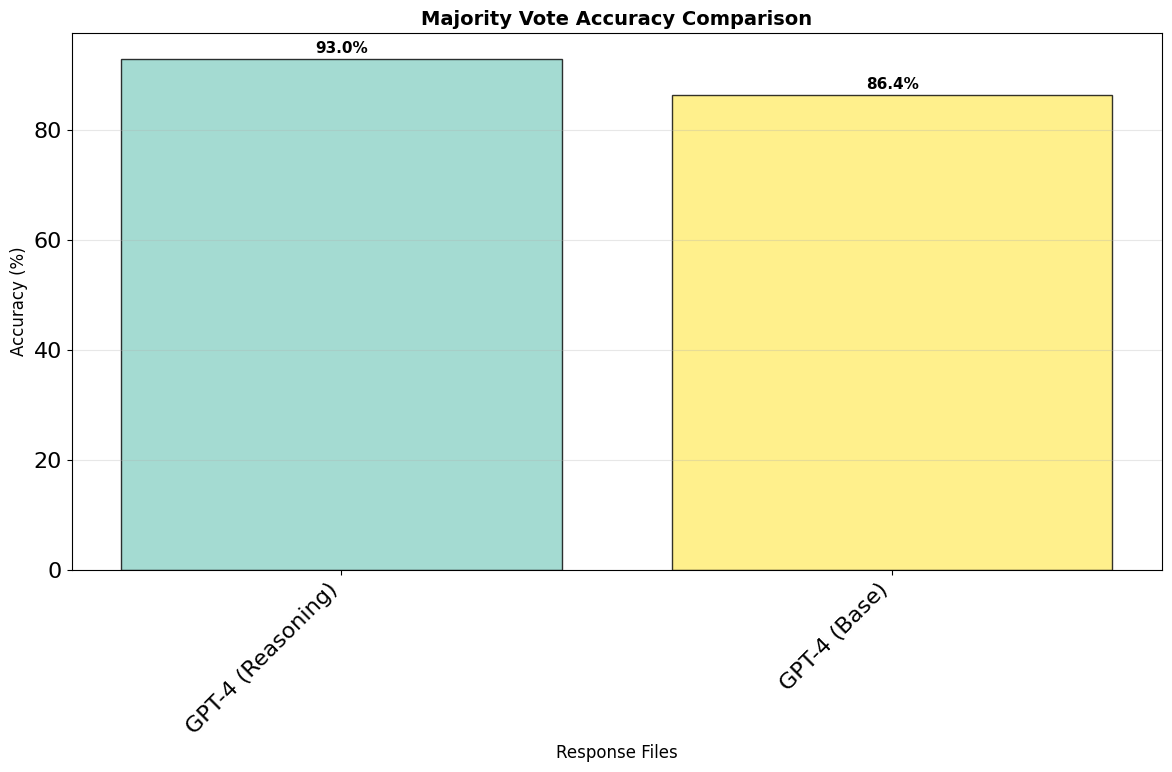

Box plot saved to: E:\Studium_Thomas\MedUni_Wien\DA\AI\llm_clinical\venv2\medqa\data\evaluation\plots\medqa_random_sampling_distribution.png


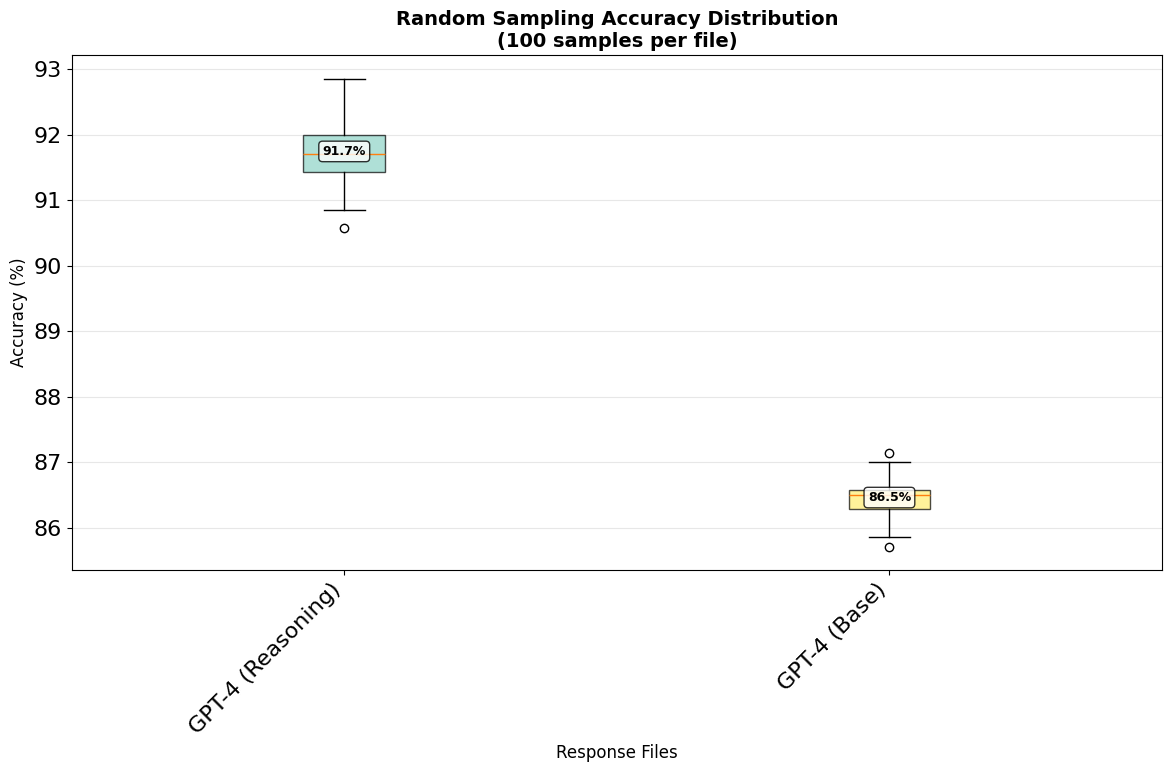


SUMMARY RESULTS
File Name                                Majority     Random Mean  Random Std   Questions 
--------------------------------------------------------------------------------
OpenAI_gpt-4.1-2025-04-14_2025-06-17-22-23-20_first700_cleaned_reason    93.00%     91.75%      0.48%      700
OpenAI_gpt-4.1-2025-04-14_2025-04-18-16-23-18_first700_cleaned_base    86.43%     86.46%      0.27%      700

📁 Plots saved to: E:\Studium_Thomas\MedUni_Wien\DA\AI\llm_clinical\venv2\medqa\data\evaluation\plots
  - medqa_majority_vote_comparison.png
  - medqa_random_sampling_distribution.png

STATISTICAL SIGNIFICANCE TESTING: MEDQA SCORES
Significance level (α): 0.05
Number of models being compared: 2

COMPARISON: GPT-4 (Reasoning) vs GPT-4 (Base)

📊 APPROACH 1: Unpaired t-test on 100 Random Samples
--------------------------------------------------------------------------------
(Tests mean MedQA score with random response selection)
GPT-4 (Reasoning):
  Mean accuracy: 91.75% ± 0.48%
GPT-4 (

In [54]:
print("="*70)
print("CALCULATING MEDQA SCORES")
print("="*70)

medqa_scores = medqa_score(RESPONSE_DIR, N=100)

if medqa_scores:
    # Run statistical significance tests
    compute_statistical_significance(medqa_scores, alpha=0.05)

print("✓ Complete")

## 6. Analysis Functions

### 6.1 Data Flattening

In [55]:
def flatten_per_question(data):
    """Original method using majority answer"""
    records = []
    for case in data:
        # Data is already at top level (no question_stats wrapper)
        majority_answer = case['most_frequent_answers'][0]
        avg_uncertainty = case['average_uncertainty'][majority_answer] / 100.0
        self_consistency = case['self_consistency'][majority_answer]
        records.append({
            'question_id': case['id'],
            'predicted_answer': majority_answer,
            'confidence': avg_uncertainty,
            'self_consistency': self_consistency,
            'is_correct': case['is_correct']
        })
    return pd.DataFrame(records)

def flatten_per_question_random(data, random_seed=42):
    """Random response method - selects one random response per question"""
    random.seed(random_seed)  # For reproducibility
    records = []
    
    for case in data:
        # Data is already at top level (no question_stats wrapper)
        
        # Get individual responses
        if 'individual_responses' in case and case['individual_responses']:
            individual_responses = case['individual_responses']
            
            # Randomly select one response key
            response_keys = list(individual_responses.keys())
            selected_key = random.choice(response_keys)
            selected_response = individual_responses[selected_key]
            
            # Get the selected response data
            answer = selected_response['answer']
            uncertainty = selected_response['uncertainty']
            
            # Convert uncertainty to confidence (0-1 scale)
            if uncertainty is not None:
                confidence = uncertainty / 100.0
            else:
                confidence = 0.5  # Default neutral confidence for missing uncertainty
            
            # Check if this random response was correct
            is_correct = (answer == case['answer_idx'])
            
            # Get self-consistency for this specific answer (how often this answer was chosen)
            self_consistency = case['self_consistency'].get(answer, 0)
            
            records.append({
                'question_id': case['id'],
                'predicted_answer': answer,
                'confidence': confidence,
                'self_consistency': self_consistency,
                'is_correct': is_correct,
                'selected_response': selected_key
            })
        else:
            # Fallback to majority method if individual_responses not available
            majority_answer = case['most_frequent_answers'][0]
            avg_uncertainty = case['average_uncertainty'][majority_answer] / 100.0
            records.append({
                'question_id': case['id'],
                'predicted_answer': majority_answer,
                'confidence': avg_uncertainty,
                'self_consistency': case['self_consistency'][majority_answer],
                'is_correct': case['is_correct'],
                'selected_response': 'majority_fallback'
            })
    
    return pd.DataFrame(records)

def flatten_all_responses(data):
    """Uses ALL individual responses - treats each response as independent sample"""
    records = []
    
    for case in data:
        # Data is already at top level (no question_stats wrapper)
        
        # Get individual responses
        if 'individual_responses' in case and case['individual_responses']:
            individual_responses = case['individual_responses']
            
            # Include ALL responses, not just one random selection
            for response_key, response_data in individual_responses.items():
                answer = response_data['answer']
                uncertainty = response_data['uncertainty']
                
                # Convert uncertainty to confidence (0-1 scale)
                if uncertainty is not None:
                    confidence = uncertainty / 100.0
                else:
                    confidence = 0.5  # Default neutral confidence for missing uncertainty
                
                # Check if this response was correct
                is_correct = (answer == case['answer_idx'])
                
                # Get self-consistency for this specific answer
                self_consistency = case['self_consistency'].get(answer, 0)
                
                records.append({
                    'question_id': case['id'],
                    'predicted_answer': answer,
                    'confidence': confidence,
                    'self_consistency': self_consistency,
                    'is_correct': is_correct,
                    'response_key': response_key
                })
        else:
            # Fallback to majority method if individual_responses not available
            majority_answer = case['most_frequent_answers'][0]
            avg_uncertainty = case['average_uncertainty'][majority_answer] / 100.0
            records.append({
                'question_id': case['id'],
                'predicted_answer': majority_answer,
                'confidence': avg_uncertainty,
                'self_consistency': case['self_consistency'][majority_answer],
                'is_correct': case['is_correct'],
                'response_key': 'majority_fallback'
            })
    
    return pd.DataFrame(records)

### 6.2 Calibration

In [56]:
def compute_calibration_metrics(y_true, y_conf, n_bins=8):

    if len(y_true) != len(y_conf):
        raise ValueError("y_true and y_conf must have same length")

    # Ensure arrays
    y_true = np.asarray(y_true)
    y_conf = np.asarray(y_conf)
    
    # Clip confidence to [0,1] to avoid edge cases
    y_conf = np.clip(y_conf, 0, 1)
    
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_conf, bins) - 1
    ece, oe, total = 0.0, 0.0, len(y_true)

    for i in range(n_bins):
        mask = bin_ids == i
        bin_size = np.sum(mask)
        if bin_size == 0: continue
        avg_conf = np.mean(y_conf[mask])
        avg_acc = np.mean(y_true[mask])
        ece += (bin_size / total) * np.abs(avg_conf - avg_acc)
        if avg_conf > avg_acc:
            oe += (bin_size / total) * (avg_conf - avg_acc)
    brier = np.mean((y_conf - y_true) ** 2)
    return {'ECE': ece, 'OE': oe, 'Brier': brier}

In [57]:
def plot_case_level_comparison(model_data_dict, n_bins=20, signal='confidence', method='majority'):
    """
    Create separate calibration and ROC plots using global clean_labels.
    
    Args:
        method: 'majority' (default), 'random', or 'all_responses' - determines which flattening method to use
    """
    
    # Get model names and create clean labels
    model_names = list(model_data_dict.keys())
    plot_labels = [get_model_label(name) for name in model_names]
    
    # Create label mapping for the legend
    label_mapping = dict(zip(model_names, plot_labels))
    
    # Choose flattening method
    if method == 'random':
        flatten_func = flatten_per_question_random
        method_label = "Random Response"
    elif method == 'all_responses':
        flatten_func = flatten_all_responses
        method_label = "All Individual Responses"
    else:
        flatten_func = flatten_per_question
        method_label = "Majority Answer"
    
    # ---- Plot 1: Calibration Curve (separate plot) ----
    plt.figure(figsize=(12, 8))
    
    for model_name, data in model_data_dict.items():
        df = flatten_func(data)
        y_true = df['is_correct'].astype(int).values
        y_conf = df[signal].values
        
        metrics = compute_calibration_metrics(y_true, y_conf, n_bins)
        prob_true, prob_pred = calibration_curve(y_true, y_conf, n_bins=n_bins)
        
        # Use clean label for legend
        clean_label = label_mapping[model_name]
        plt.plot(prob_pred, prob_true, marker='o', markersize=6, 
                label=f"{clean_label} (ECE={metrics['ECE']:.3f})")
    
    plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.8)
    plt.xlabel("Predicted Confidence", fontsize=12)
    plt.ylabel("Empirical Accuracy", fontsize=12)
    plt.title(f"Calibration Curve - {method_label} (signal: {signal})", fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Save calibration plot
    output_dir = os.path.join(EVAL_PATH, 'plots')
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, f'calibration_curve_{signal}_{method}.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # ---- Plot 2: ROC Curve (separate plot) ----
    plt.figure(figsize=(12, 8))
    
    for model_name, data in model_data_dict.items():
        df = flatten_func(data)
        y_true = df['is_correct'].astype(int).values
        y_conf = df[signal].values
        
        fpr, tpr, _ = roc_curve(y_true, y_conf)
        auc = roc_auc_score(y_true, y_conf)
        
        # Use clean label for legend
        clean_label = label_mapping[model_name]
        plt.plot(fpr, tpr, label=f'{clean_label} (AUROC={auc:.3f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.8)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title(f"ROC Curve - {method_label} (signal: {signal})", fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Save ROC plot
    plt.savefig(os.path.join(output_dir, f'roc_curve_{signal}_{method}.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Plots saved to: {output_dir}")
    print(f"  - calibration_curve_{signal}_{method}.png")
    print(f"  - roc_curve_{signal}_{method}.png")

### 6.3 Entropy

In [65]:
def calculate_medqa_entropy(all_model_data, output_dir):
    """
    Calculate response entropy for MedQA data using categorical letters directly.
    Entropy is the appropriate measure for categorical data like answer choices.
    """
    results = {}
    
    for model_key, data_list in all_model_data.items():
        question_entropies = []
        question_unique_counts = []
        question_disagreement_rates = []
        question_ids = []  # Track question IDs for paired testing
        
        for case in data_list:
            question_id = case.get('id')  # Get question ID
            
            # Data is at top level (no question_stats wrapper)
            if 'individual_responses' in case and case['individual_responses']:
                individual_responses = case['individual_responses']
                
                if individual_responses and len(individual_responses) > 1:
                    # Get answer letters directly (no number conversion)
                    answers = []
                    for response_data in individual_responses.values():
                        answer = response_data['answer']
                        answers.append(answer)
                    
                    if len(answers) > 1:
                        # Calculate entropy directly from categorical data
                        answer_counts = Counter(answers)
                        total = len(answers)
                        entropy = 0
                        for count in answer_counts.values():
                            if count > 0:
                                prob = count / total
                                entropy -= prob * np.log2(prob)
                        question_entropies.append(entropy)
                        question_ids.append(question_id)  # Store question ID
                        
                        # Additional categorical measures
                        unique_answers = len(answer_counts)
                        question_unique_counts.append(unique_answers)
                        
                        # Disagreement rate (fraction not choosing modal answer)
                        modal_count = max(answer_counts.values())
                        disagreement_rate = (total - modal_count) / total
                        question_disagreement_rates.append(disagreement_rate)
        
        if question_entropies:
            results[model_key] = {
                'mean_entropy': np.mean(question_entropies),
                'std_entropy': np.std(question_entropies),
                'mean_unique_answers': np.mean(question_unique_counts),
                'mean_disagreement_rate': np.mean(question_disagreement_rates),
                'question_entropies': question_entropies,
                'question_ids': question_ids,  # Store question IDs
                'question_unique_counts': question_unique_counts,
                'question_disagreement_rates': question_disagreement_rates,
                'n_questions': len(question_entropies)
            }
    
    # Create visualizations
    if results:
        plot_medqa_entropy(results, output_dir)
    
    return results


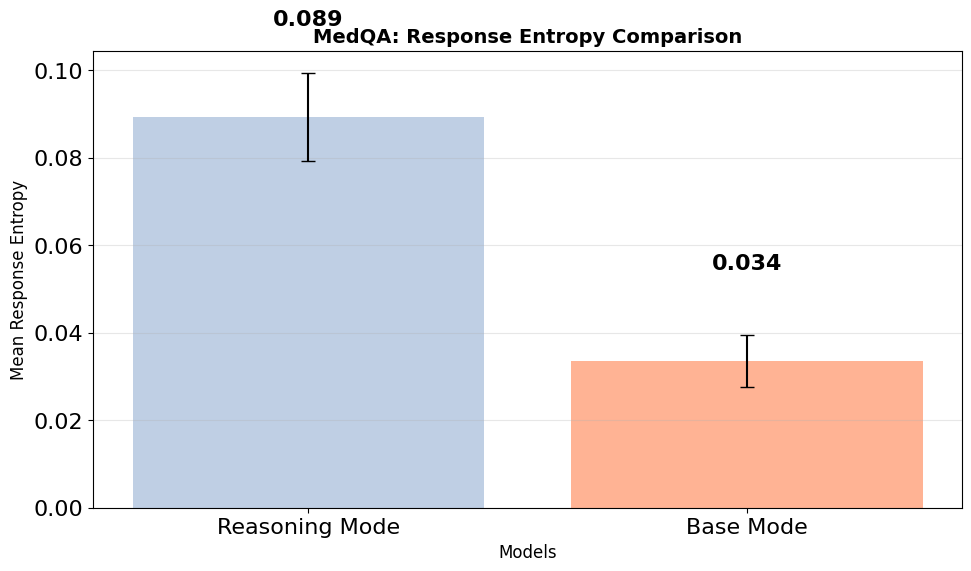

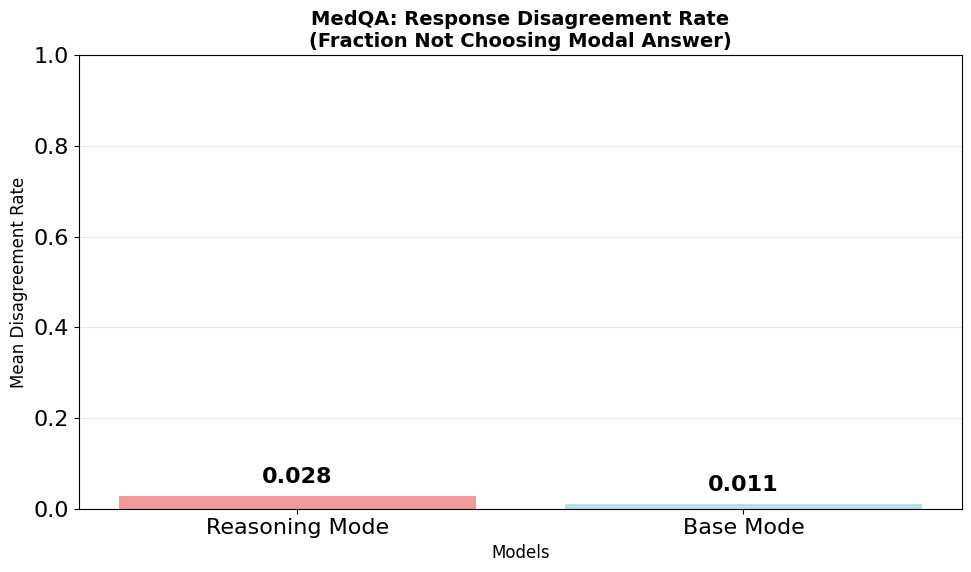

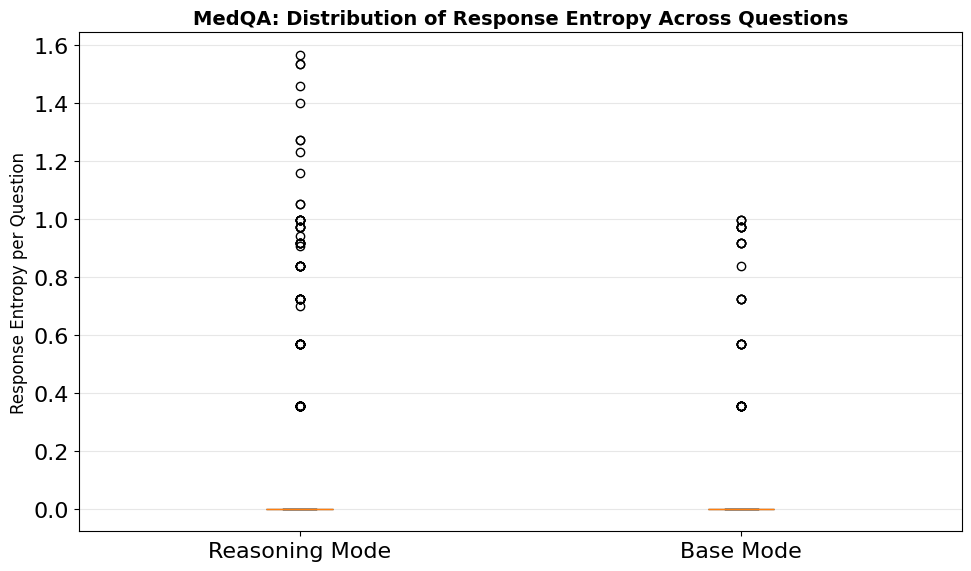

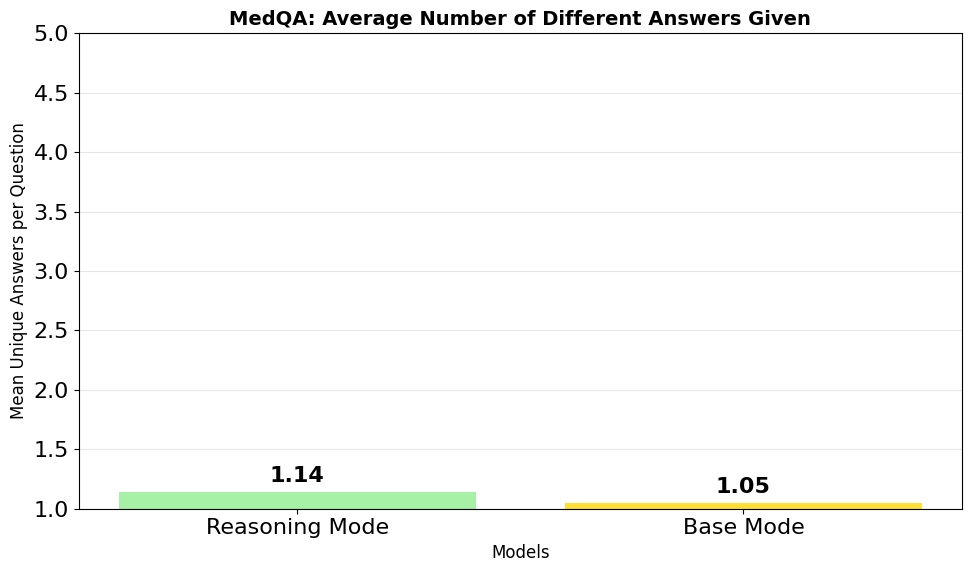


MEDQA ENTROPY ANALYSIS RESULTS
Reasoning Mode:
  Mean Entropy: 0.0893 (±0.2670)
  Mean Disagreement Rate: 0.0282
  Mean Unique Answers: 1.14
  Questions: 700

Base Mode:
  Mean Entropy: 0.0336 (±0.1572)
  Mean Disagreement Rate: 0.0110
  Mean Unique Answers: 1.05
  Questions: 700



In [66]:
def plot_medqa_entropy(results, output_dir):
    """Create entropy plots for MedQA categorical data"""
    os.makedirs(output_dir, exist_ok=True)
    
    model_names = list(results.keys())
    clean_labels = [get_model_label(name) for name in model_names]
    
    # Plot 1: Mean Entropy Comparison
    plt.figure(figsize=(10, 6))
    
    entropies = [results[model]['mean_entropy'] for model in model_names]
    entropy_std_errors = [results[model]['std_entropy'] / np.sqrt(results[model]['n_questions']) 
                          for model in model_names]
    
    bars = plt.bar(range(len(model_names)), entropies, yerr=entropy_std_errors, 
                   capsize=5, alpha=0.8, color=['lightsteelblue', 'lightsalmon'][:len(model_names)])
    
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Mean Response Entropy', fontsize=12)
    plt.title('MedQA: Response Entropy Comparison', 
              fontsize=14, fontweight='bold')
    plt.xticks(range(len(model_names)), clean_labels)
    plt.grid(True, alpha=0.3, axis='y')
    
    for bar, ent in zip(bars, entropies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{ent:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'medqa_entropy_comparison.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 2: Mean Disagreement Rate
    plt.figure(figsize=(10, 6))
    
    disagreement_rates = [results[model]['mean_disagreement_rate'] for model in model_names]
    
    bars = plt.bar(range(len(model_names)), disagreement_rates, 
                   alpha=0.8, color=['lightcoral', 'lightblue'][:len(model_names)])
    
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Mean Disagreement Rate', fontsize=12)
    plt.title('MedQA: Response Disagreement Rate\n(Fraction Not Choosing Modal Answer)', 
              fontsize=14, fontweight='bold')
    plt.xticks(range(len(model_names)), clean_labels)
    plt.grid(True, alpha=0.3, axis='y')
    plt.ylim(0, 1)
    
    for bar, rate in zip(bars, disagreement_rates):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'medqa_disagreement_rate.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 3: Entropy Distribution
    plt.figure(figsize=(10, 6))
    
    entropy_data = [results[model]['question_entropies'] for model in model_names]
    
    box_plot = plt.boxplot(entropy_data, tick_labels=clean_labels, patch_artist=True)
    plt.ylabel('Response Entropy per Question', fontsize=12)
    plt.title('MedQA: Distribution of Response Entropy Across Questions', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    
    colors = ['lightsteelblue', 'lightsalmon']
    for patch, color in zip(box_plot['boxes'], colors[:len(model_names)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'medqa_entropy_distribution.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot 4: Average Unique Answers
    plt.figure(figsize=(10, 6))
    
    unique_counts = [results[model]['mean_unique_answers'] for model in model_names]
    
    bars = plt.bar(range(len(model_names)), unique_counts, 
                   alpha=0.8, color=['lightgreen', 'gold'][:len(model_names)])
    
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Mean Unique Answers per Question', fontsize=12)
    plt.title('MedQA: Average Number of Different Answers Given', 
              fontsize=14, fontweight='bold')
    plt.xticks(range(len(model_names)), clean_labels)
    plt.grid(True, alpha=0.3, axis='y')
    plt.ylim(1, 5)  # Max 5 possible answers (A-E)
    
    for bar, count in zip(bars, unique_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{count:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'medqa_unique_answers.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print results
    print("\n" + "="*60)
    print("MEDQA ENTROPY ANALYSIS RESULTS")
    print("="*60)
    for model_name in model_names:
        clean_name = get_model_label(model_name)
        r = results[model_name]
        print(f"{clean_name}:")
        print(f"  Mean Entropy: {r['mean_entropy']:.4f} (±{r['std_entropy']:.4f})")
        print(f"  Mean Disagreement Rate: {r['mean_disagreement_rate']:.4f}")
        print(f"  Mean Unique Answers: {r['mean_unique_answers']:.2f}")
        print(f"  Questions: {r['n_questions']}")
        print()

# Run the analysis
variance_output_dir = os.path.join(EVAL_PATH, 'plots', 'variance_analysis')
medqa_entropy_results = calculate_medqa_entropy(all_model_data, variance_output_dir)

In [67]:
def compute_entropy_statistical_significance(results, alpha=0.05):
    """
    Compute statistical significance for entropy differences between models using paired t-test.
    
    Args:
        results: Dictionary with entropy results from calculate_medqa_entropy()
        alpha: Significance level (default 0.05)
    """
    model_names = list(results.keys())
    
    if len(model_names) < 2:
        print(f"\n⚠️  Statistical testing requires at least 2 models. Found {len(model_names)} model(s).")
        return
    
    print("\n" + "="*80)
    print("STATISTICAL SIGNIFICANCE TESTING: RESPONSE ENTROPY")
    print("="*80)
    print(f"Significance level (α): {alpha}")
    print(f"Number of models being compared: {len(model_names)}")
    print("="*80)
    
    # Perform pairwise comparisons
    for model1, model2 in combinations(model_names, 2):
        # Get clean labels
        label1 = get_model_label(model1)
        label2 = get_model_label(model2)
        
        print(f"\n{'='*80}")
        print(f"COMPARISON: {label1} vs {label2}")
        print(f"{'='*80}")
        
        result1 = results[model1]
        result2 = results[model2]
        
        # ========================================================================
        # Paired t-test on question-level entropy values
        # ========================================================================
        print(f"\n📊 Paired t-test on Question-Level Entropy")
        print("-" * 80)
        
        # Get per-question entropy
        question_entropies1_dict = {qid: ent for qid, ent in zip(result1['question_ids'], result1['question_entropies'])}
        question_entropies2_dict = {qid: ent for qid, ent in zip(result2['question_ids'], result2['question_entropies'])}
        
        # Find common questions
        common_questions = sorted(set(question_entropies1_dict.keys()) & set(question_entropies2_dict.keys()))
        n_common = len(common_questions)
        
        if n_common == 0:
            print("  ⚠️  No common questions found between models.")
            continue
        
        print(f"Common questions: {n_common}")
        
        # Create paired arrays
        entropies1 = [question_entropies1_dict[qid] for qid in common_questions]
        entropies2 = [question_entropies2_dict[qid] for qid in common_questions]
        
        # Calculate mean entropies
        mean1 = np.mean(entropies1)
        mean2 = np.mean(entropies2)
        std1 = np.std(entropies1)
        std2 = np.std(entropies2)
        
        print(f"{label1}:")
        print(f"  Mean entropy: {mean1:.4f} ± {std1:.4f}")
        print(f"{label2}:")
        print(f"  Mean entropy: {mean2:.4f} ± {std2:.4f}")
        print(f"Difference: {mean2 - mean1:+.4f}")
        
        # Perform paired t-test
        try:
            t_stat, p_value = ttest_rel(entropies2, entropies1)
            print(f"\nPaired t-test results:")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.6f}")
            
            if p_value < alpha:
                print(f"  ✓ SIGNIFICANT difference (p < {alpha})")
                if mean2 > mean1:
                    print(f"  → {label2} has significantly HIGHER entropy than {label1}")
                    print(f"     (More variable/inconsistent responses)")
                else:
                    print(f"  → {label1} has significantly HIGHER entropy than {label2}")
                    print(f"     (More variable/inconsistent responses)")
            else:
                print(f"  ✗ NO significant difference (p >= {alpha})")
                print(f"     (Response consistency is similar between models)")
                
        except Exception as e:
            print(f"  ⚠️  Paired t-test failed: {e}")

print("✓ Entropy statistical significance function loaded")

✓ Entropy statistical significance function loaded


### 6.4 Strategy Analysis

In [75]:
def normalize_strategy_to_official(strategy):
    """
    Normalize strategy names to map to the 12 official clinical reasoning categories.
    Returns 'other' for strategies that don't clearly fit the official categories.
    """
    if not strategy or not isinstance(strategy, str):
        return "other"
    
    # Convert to lowercase and clean
    normalized = strategy.lower().strip()
    normalized = re.sub(r'[^\w\s-]', '', normalized)  # Remove punctuation except hyphens
    normalized = re.sub(r'\s+', ' ', normalized)  # Normalize whitespace
    normalized = normalized.strip()
    
    # Official strategy categories (12 total: 10 + 2 new)
    official_categories = {
        'deductive': 'Deductive Reasoning',
        'hypothetico-deductive': 'Hypothetico-Deductive Reasoning', 
        'inductive': 'Inductive Reasoning',
        'abductive': 'Abductive Reasoning',
        'probabilistic': 'Probabilistic Reasoning',
        'rule-based': 'Rule-Based / Categorical / Deterministic Reasoning',
        'causal': 'Causal Reasoning',
        'heuristic': 'Heuristic / Pattern Recognition (Fast Thinking)',
        'red-flag': 'Red Flag / Rule-Out Reasoning',
        'guideline-based': 'Guideline-Based Reasoning',
        'ethical': 'Ethical Reasoning',
        'patient-centered': 'Patient-Centered Risk-Benefit Analysis'
    }
    
    # Comprehensive mapping to official categories
    strategy_mapping = {
        # Deductive Reasoning
        'deductive': 'deductive',
        'deduction': 'deductive',
        'deductive reasoning': 'deductive',
        'top down': 'deductive',
        'top-down': 'deductive',
        'rule application': 'deductive',
        'principle based': 'deductive',
        'principle-based': 'deductive',
        
        # Hypothetico-Deductive Reasoning
        'hypothetico-deductive': 'hypothetico-deductive',
        'hypothetico deductive': 'hypothetico-deductive',
        'hypothetical-deductive': 'hypothetico-deductive',
        'hypothetical deductive': 'hypothetico-deductive',
        'hypothesis testing': 'hypothetico-deductive',
        'hypothesis-driven': 'hypothetico-deductive',
        'hypothesis driven': 'hypothetico-deductive',
        'differential reasoning': 'hypothetico-deductive',
        'multiple hypothesis': 'hypothetico-deductive',
        'hypothetico-deductive reasoning': 'hypothetico-deductive',
        'differential diagnosis': 'hypothetico-deductive',
        'differential': 'hypothetico-deductive',
        
        # Inductive Reasoning
        'inductive': 'inductive',
        'induction': 'inductive',
        'inductive reasoning': 'inductive',
        'bottom up': 'inductive',
        'bottom-up': 'inductive',
        'data driven': 'inductive',
        'data-driven': 'inductive',
        'pattern synthesis': 'inductive',
        
        # Abductive Reasoning
        'abductive': 'abductive',
        'abduction': 'abductive',
        'abductive reasoning': 'abductive',
        'inference to best explanation': 'abductive',
        'best explanation': 'abductive',
        'backwards reasoning': 'abductive',
        'reverse reasoning': 'abductive',
        'explanatory reasoning': 'abductive',
        
        # Probabilistic Reasoning
        'probabilistic': 'probabilistic',
        'probability': 'probabilistic',
        'probabilistic reasoning': 'probabilistic',
        'bayesian': 'probabilistic',
        'likelihood': 'probabilistic',
        'statistical': 'probabilistic',
        'risk based': 'probabilistic',
        'risk-based': 'probabilistic',
        'pretest probability': 'probabilistic',
        'post-test probability': 'probabilistic',
        'prevalence': 'probabilistic',
        
        # Rule-Based / Categorical / Deterministic Reasoning
        'rule-based': 'rule-based',
        'rule based': 'rule-based',
        'categorical': 'rule-based',
        'deterministic': 'rule-based',
        'criteria based': 'rule-based',
        'criteria-based': 'rule-based',
        'threshold': 'rule-based',
        'cutoff': 'rule-based',
        'scoring system': 'rule-based',
        'decision rule': 'rule-based',
        'clinical decision rule': 'rule-based',
        'algorithmic': 'rule-based',
        'algorithm': 'rule-based',
        
        # Causal Reasoning (expanded to include anatomical/physiological knowledge)
        'causal': 'causal',
        'causation': 'causal',
        'causal reasoning': 'causal',
        'pathophysiologic': 'causal',
        'pathophysiology': 'causal',
        'pathophysiological': 'causal',
        'mechanistic': 'causal',
        'mechanism': 'causal',
        'cause effect': 'causal',
        'cause-effect': 'causal',
        'physiologic': 'causal',
        'physiological': 'causal',
        'anatomical': 'causal',
        'anatomy': 'causal',
        'anatomical knowledge': 'causal',
        'physiological knowledge': 'causal',
        'pathophysiological knowledge': 'causal',
        'biochemical': 'causal',
        'molecular': 'causal',
        'pharmacological': 'causal',
        'pharmacology': 'causal',
        'pharmacokinetic': 'causal',
        'pharmacodynamic': 'causal',
        
        # Heuristic / Pattern Recognition (Fast Thinking)
        'heuristic': 'heuristic',
        'heuristics': 'heuristic',
        'pattern recognition': 'heuristic',
        'pattern matching': 'heuristic',
        'pattern': 'heuristic',
        'recognition': 'heuristic',
        'intuitive': 'heuristic',
        'intuition': 'heuristic',
        'fast thinking': 'heuristic',
        'system 1': 'heuristic',
        'gut feeling': 'heuristic',
        'clinical intuition': 'heuristic',
        'gestalt': 'heuristic',
        
        # Red Flag / Rule-Out Reasoning
        'red flag': 'red-flag',
        'red-flag': 'red-flag',
        'rule out': 'red-flag',
        'rule-out': 'red-flag',
        'ruling out': 'red-flag',
        'exclusion': 'red-flag',
        'exclude': 'red-flag',
        'worst case': 'red-flag',
        'worst-case': 'red-flag',
        'emergency': 'red-flag',
        'critical': 'red-flag',
        'life threatening': 'red-flag',
        'life-threatening': 'red-flag',
        'safety first': 'red-flag',
        'dont miss': 'red-flag',
        'cannot miss': 'red-flag',
        
        # Guideline-Based Reasoning
        'guideline-based': 'guideline-based',
        'guideline based': 'guideline-based',
        'guideline': 'guideline-based',
        'guidelines': 'guideline-based',
        'protocol': 'guideline-based',
        'protocols': 'guideline-based',
        'evidence-based': 'guideline-based',
        'evidence based': 'guideline-based',
        'standard of care': 'guideline-based',
        'best practice': 'guideline-based',
        'best practices': 'guideline-based',
        'recommendation': 'guideline-based',
        'recommendations': 'guideline-based',
        'consensus': 'guideline-based',
        
        # NEW: Ethical Reasoning
        'ethical': 'ethical',
        'ethics': 'ethical',
        'ethical reasoning': 'ethical',
        'medical ethics': 'ethical',
        'bioethics': 'ethical',
        'ethical principles': 'ethical',
        'autonomy': 'ethical',
        'beneficence': 'ethical',
        'non-maleficence': 'ethical',
        'nonmaleficence': 'ethical',
        'justice': 'ethical',
        'veracity': 'ethical',
        'informed consent': 'ethical',
        'patient rights': 'ethical',
        'professional integrity': 'ethical',
        'moral': 'ethical',
        'morality': 'ethical',
        
        # NEW: Patient-Centered Risk-Benefit Analysis
        'risk': 'patient-centered',
        'benefit': 'patient-centered',
        'risk benefit': 'patient-centered',
        'risk-benefit': 'patient-centered',
        'patient centered': 'patient-centered',
        'patient-centered': 'patient-centered',
        'patient benefit': 'patient-centered',
        'patient risk': 'patient-centered',
        'harm': 'patient-centered',
        'adverse effects': 'patient-centered',
        'side effects': 'patient-centered',
        'complications': 'patient-centered',
        'patient safety': 'patient-centered',
        'quality of life': 'patient-centered',
        'patient preferences': 'patient-centered',
        'shared decision': 'patient-centered',
        'individualized': 'patient-centered',
        'personalized': 'patient-centered',
    }
    
    # Try exact match first
    if normalized in strategy_mapping:
        category = strategy_mapping[normalized]
        return official_categories[category]
    
    # Try partial matches for compound strategies - LONGEST FIRST to avoid conflicts
    # Sort by length descending so "hypothetico-deductive" is checked before "deductive"
    sorted_keys = sorted(strategy_mapping.items(), key=lambda x: len(x[0]), reverse=True)
    for key, category in sorted_keys:
        if key in normalized:
            return official_categories[category]
    
    # Check if it contains key words from official categories (also longest first)
    for key, category in sorted_keys:
        if any(word in normalized for word in key.split()):
            return official_categories[category]
    
    # If no mapping found, return 'other'
    return "other"


In [76]:
def analyze_strategies_official_categories_medqa(model_data_dict, output_dir):
    """
    Analyze reasoning strategies using official clinical reasoning categories.
    Creates 4 separate plots instead of subplots, using clean labels.
    """
    
    # Official clinical reasoning categories - UPDATED to include 12 categories
    official_categories = [
        'Deductive Reasoning',
        'Hypothetico-Deductive Reasoning', 
        'Inductive Reasoning',
        'Abductive Reasoning',
        'Probabilistic Reasoning',
        'Rule-Based / Categorical / Deterministic Reasoning',
        'Causal Reasoning',
        'Heuristic / Pattern Recognition (Fast Thinking)',
        'Red Flag / Rule-Out Reasoning',
        'Guideline-Based Reasoning',
        'Ethical Reasoning',
        'Risk-Benefit Analysis'
    ]
    
    short_labels = {
        'Deductive Reasoning': 'Deductive',
        'Hypothetico-Deductive Reasoning': 'Hypothetico-\nDeductive', 
        'Inductive Reasoning': 'Inductive',
        'Abductive Reasoning': 'Abductive',
        'Probabilistic Reasoning': 'Probabilistic',
        'Rule-Based / Categorical / Deterministic Reasoning': 'Rule-Based /\nCategorical',
        'Causal Reasoning': 'Causal',
        'Heuristic / Pattern Recognition (Fast Thinking)': 'Heuristic /\nPattern Recog',
        'Red Flag / Rule-Out Reasoning': 'Red Flag /\nRule-Out',
        'Guideline-Based Reasoning': 'Guideline-\nBased',
        'Ethical Reasoning': 'Ethical',
        'Risk-Benefit Analysis': 'Risk-Benefit\nAnalysis',
        'other': 'Other'
    }
    
    # Get model names and create clean labels for this function
    model_names = list(model_data_dict.keys())
    
    # Create clean labels for plotting
    plot_labels = [get_model_label(name) for name in model_names]
    
    # Create label mapping
    label_mapping = dict(zip(model_names, plot_labels))
    
    # First pass: Check which models actually have strategies
    models_with_strategies = []
    for model_name, data in model_data_dict.items():
        strategy_count = 0
        for case in data:
            # Data is at top level (no question_stats wrapper)
            if case.get('strategies') and isinstance(case['strategies'], dict):
                # Sum up all strategy counts
                strategy_count += sum(case['strategies'].values())
        
        if strategy_count > 0:
            models_with_strategies.append(model_name)
            print(f"✅ {label_mapping[model_name]}: Found {strategy_count} strategies")
        else:
            print(f"⏭️ {label_mapping[model_name]}: No strategies found - skipping analysis")
    
    if not models_with_strategies:
        print("\n❌ No models with strategies found. Strategy analysis cannot be performed.")
        return
    
    print(f"\n📊 Analyzing strategies for {len(models_with_strategies)} model(s) with strategy data...")
    
    # Second pass: Analyze only models with strategies
    for model_name in models_with_strategies:
        data = model_data_dict[model_name]
        clean_model_name = label_mapping[model_name]
        
        print(f"\n🔍 Analyzing reasoning strategies for {clean_model_name}...")
        
        # Extract strategies from each case
        all_strategies = []
        strategy_correctness = []
        
        for case in data:
            # Data is at top level (no question_stats wrapper)
            is_correct = case.get('is_correct', False)
            
            # Handle the actual data format: strategies as dict with counts
            if case.get('strategies') and isinstance(case['strategies'], dict):
                for strategy_name, count in case['strategies'].items():
                    # Add each strategy the number of times it was mentioned
                    for _ in range(count):
                        normalized_strategy = normalize_strategy_to_official(strategy_name)
                        all_strategies.append(normalized_strategy)
                        strategy_correctness.append((normalized_strategy, is_correct))
        
        # Count strategies
        strategy_counts_all = Counter(all_strategies)
        strategy_counts_correct = Counter([s for s, correct in strategy_correctness if correct])
        strategy_counts_incorrect = Counter([s for s, correct in strategy_correctness if not correct])
        
        # Only include categories that are actually used (from our 12 official categories + other)
        used_categories = [cat for cat in official_categories + ['other'] if strategy_counts_all[cat] > 0]
        
        # Use clean label for display
        clean_model_name = label_mapping[model_name]
        
        # Plot 1: Overall distribution (separate plot)
        plt.figure(figsize=(12, 8))
        counts = [strategy_counts_all[cat] for cat in used_categories]
        labels = [short_labels[cat] for cat in used_categories]
        
        bars1 = plt.bar(range(len(used_categories)), counts, alpha=0.8, 
                       color=plt.cm.Set3(np.linspace(0, 1, len(used_categories))))
        plt.title(f'Distribution of Reasoning Strategies - {clean_model_name}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Strategy Categories', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.xticks(range(len(used_categories)), labels, rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        
        # Add count labels
        for bar, count in zip(bars1, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                    str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'strategy_distribution_{model_name}.png'), 
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        # Plot 2: Correct vs Incorrect (separate plot)
        plt.figure(figsize=(12, 8))
        correct_counts = [strategy_counts_correct.get(cat, 0) for cat in used_categories]
        incorrect_counts = [strategy_counts_incorrect.get(cat, 0) for cat in used_categories]
        
        x = np.arange(len(used_categories))
        width = 0.35
        
        bars2a = plt.bar(x - width/2, correct_counts, width, label='Correct Answer', 
                        alpha=0.8, color='lightgreen')
        bars2b = plt.bar(x + width/2, incorrect_counts, width, label='Incorrect Answer', 
                        alpha=0.8, color='lightcoral')
        
        plt.title(f'Strategy Usage by Answer Correctness - {clean_model_name}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Strategy Categories', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.xticks(x, labels, rotation=45, ha='right')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'strategy_correctness_{model_name}.png'), 
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        # Plot 3: Effectiveness rates (separate plot)
        plt.figure(figsize=(12, 8))
        success_rates = []
        for cat in used_categories:
            correct_count = strategy_counts_correct.get(cat, 0)
            total_count = strategy_counts_all.get(cat, 0)
            rate = correct_count / total_count * 100 if total_count > 0 else 0
            success_rates.append(rate)
        
        colors = ['darkgreen' if rate >= 60 else 'gold' if rate >= 40 else 'lightcoral' 
                 for rate in success_rates]
        
        bars3 = plt.bar(range(len(used_categories)), success_rates, alpha=0.8, color=colors)
        plt.title(f'Strategy Effectiveness (% Correct Answers) - {clean_model_name}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Strategy Categories', fontsize=12)
        plt.ylabel('Correct Answer Rate (%)', fontsize=12)
        plt.xticks(range(len(used_categories)), labels, rotation=45, ha='right')
        plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='50% baseline')
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3, axis='y')
        
        for bar, rate in zip(bars3, success_rates):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                    f'{rate:.0f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'strategy_effectiveness_{model_name}.png'), 
                    dpi=300, bbox_inches='tight')
        plt.show()
        
        # Plot 4: Pie chart (separate plot)
        plt.figure(figsize=(10, 10))
        wedges, texts, autotexts = plt.pie(counts, labels=labels, autopct='%1.1f%%', 
                                          colors=plt.cm.Set3(np.linspace(0, 1, len(used_categories))))
        plt.title(f'Strategy Distribution (Proportional) - {clean_model_name}', 
                 fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'strategy_pie_chart_{model_name}.png'), 
                    dpi=300, bbox_inches='tight')
        plt.show()

        # Print summary
        print(f"\n--- Official Category Summary for {clean_model_name} ---")
        print(f"Strategies mapped to official categories: {len([s for s in all_strategies if s != 'other'])}")
        print(f"Strategies categorized as 'other': {strategy_counts_all['other']}")
        
        print(f"\nOfficial category usage (ranked by frequency):")
        for i, (category, count) in enumerate(strategy_counts_all.most_common(), 1):
            if count > 0:
                success_rate = strategy_counts_correct.get(category, 0) / count * 100
                print(f"  {i:2d}. {category}: {count} uses, {success_rate:.1f}% success")

---
## 7. Execute Analyses

### 7.1 Calibration & ROC Curves

Generating calibration plots...



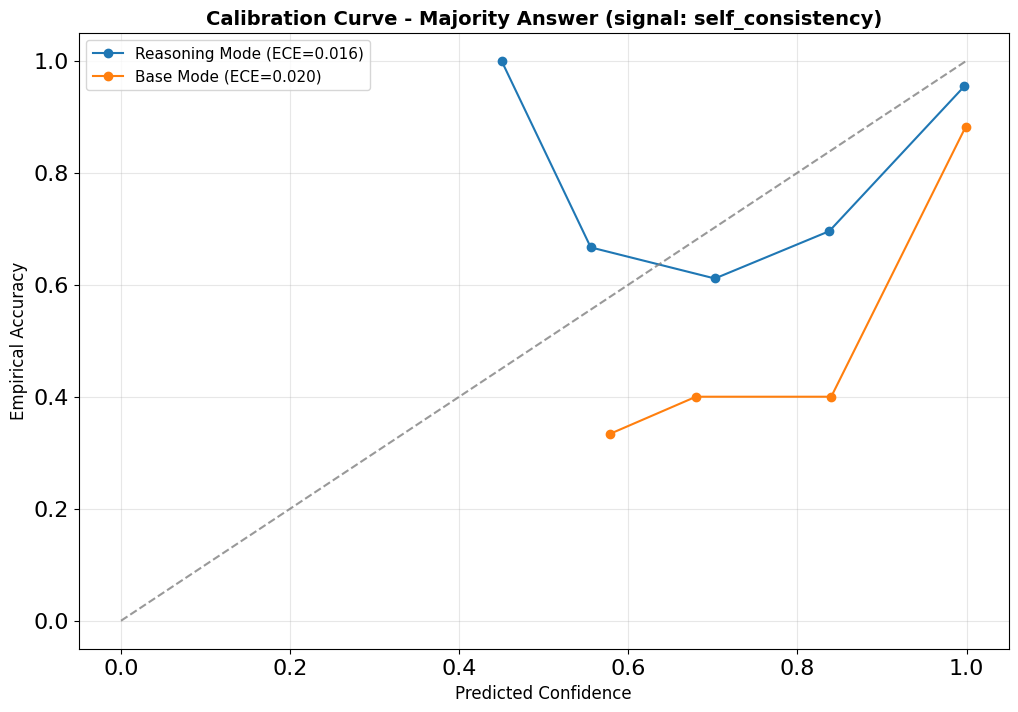

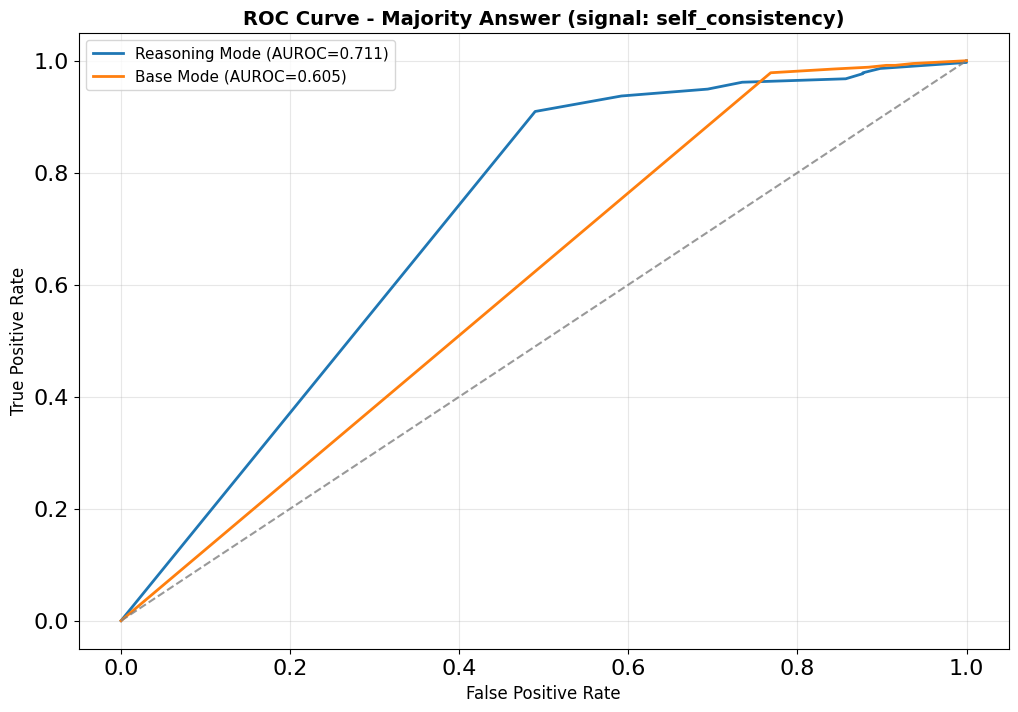

Plots saved to: E:\Studium_Thomas\MedUni_Wien\DA\AI\llm_clinical\venv2\medqa\data\evaluation\plots
  - calibration_curve_self_consistency_majority.png
  - roc_curve_self_consistency_majority.png


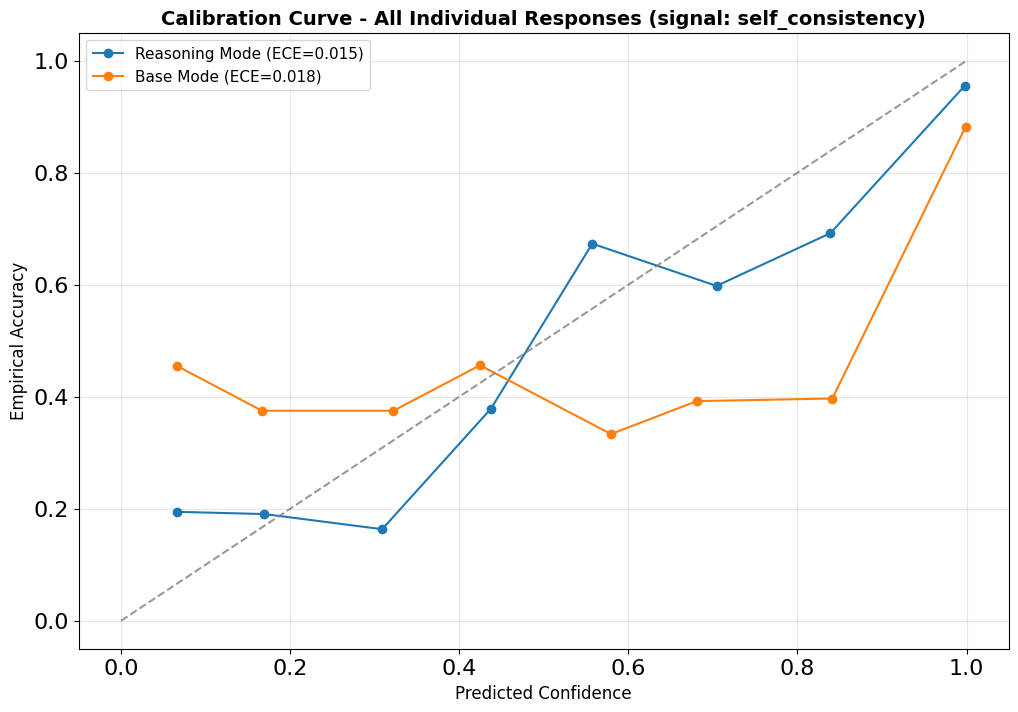

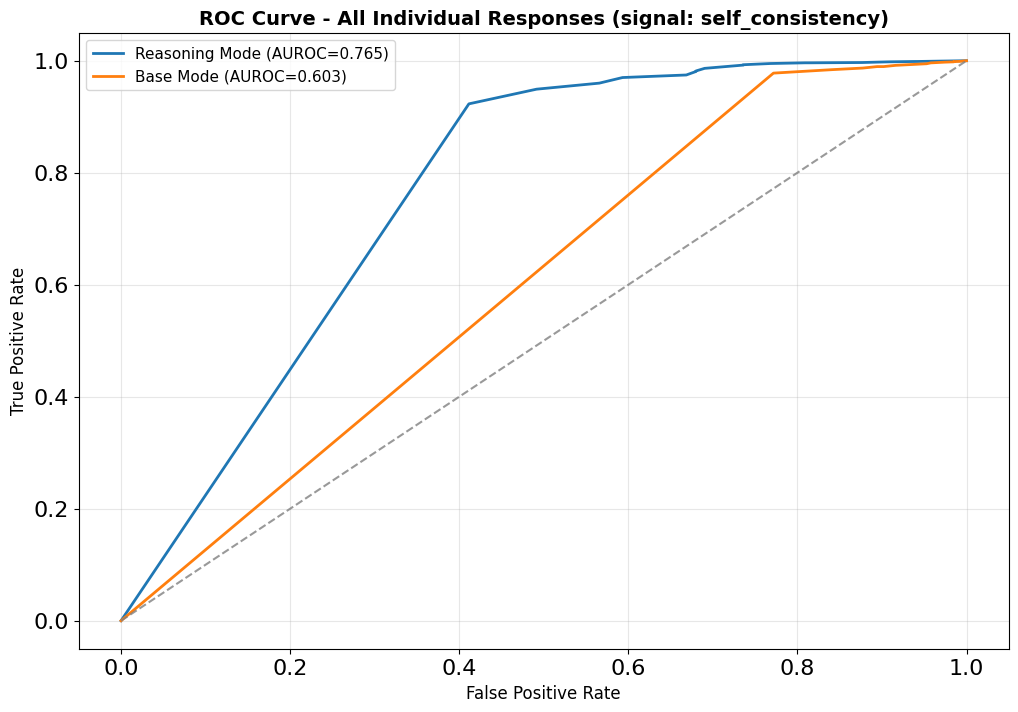

Plots saved to: E:\Studium_Thomas\MedUni_Wien\DA\AI\llm_clinical\venv2\medqa\data\evaluation\plots
  - calibration_curve_self_consistency_all_responses.png
  - roc_curve_self_consistency_all_responses.png


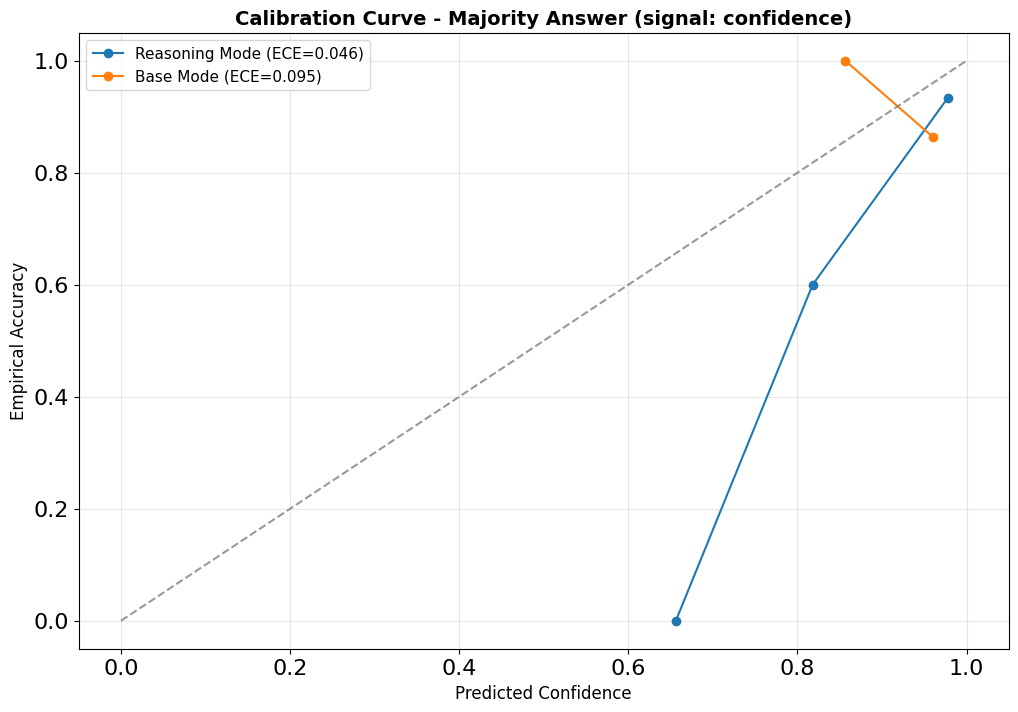

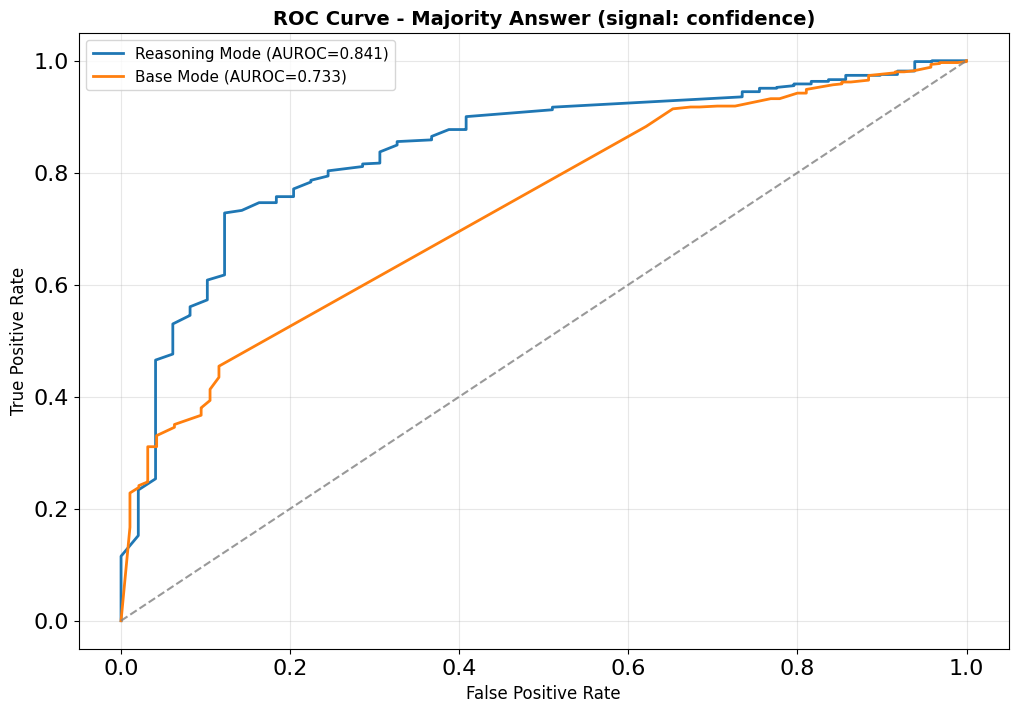

Plots saved to: E:\Studium_Thomas\MedUni_Wien\DA\AI\llm_clinical\venv2\medqa\data\evaluation\plots
  - calibration_curve_confidence_majority.png
  - roc_curve_confidence_majority.png


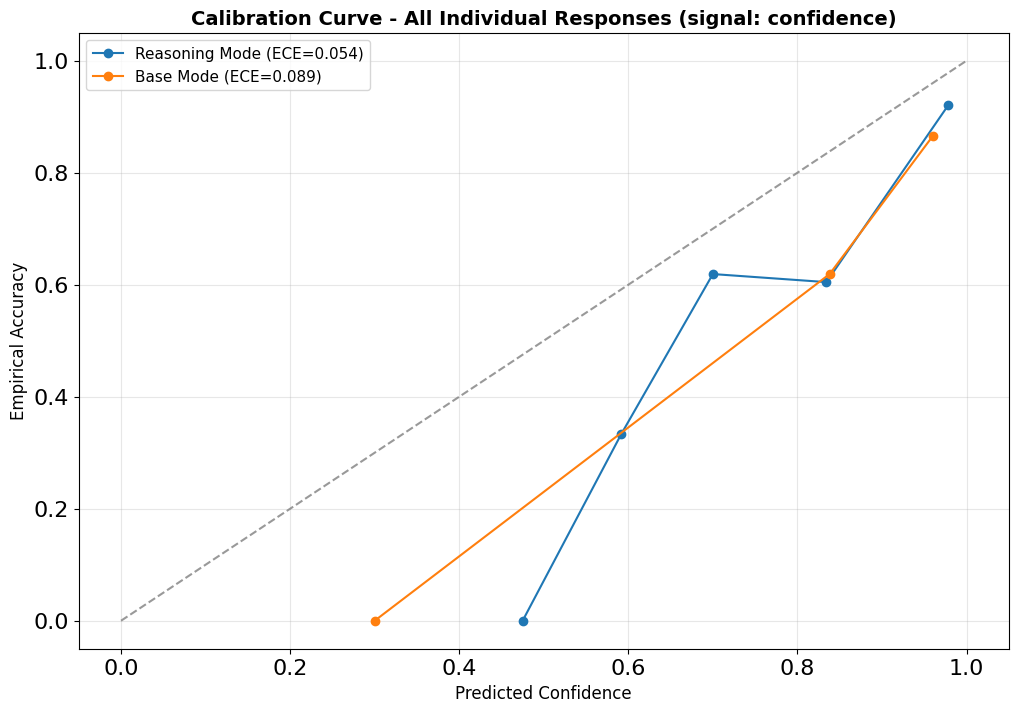

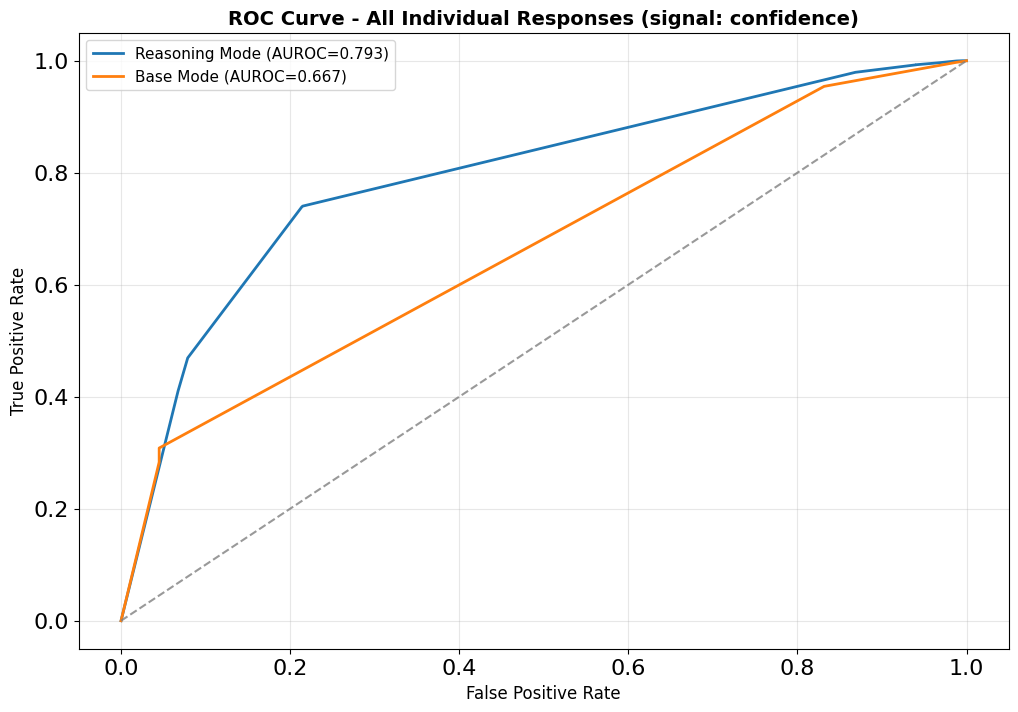

Plots saved to: E:\Studium_Thomas\MedUni_Wien\DA\AI\llm_clinical\venv2\medqa\data\evaluation\plots
  - calibration_curve_confidence_all_responses.png
  - roc_curve_confidence_all_responses.png
✓ Calibration complete


In [58]:
# Optional: custom labels
# Model labels are configured in the configuration section (cell c5)

print("Generating calibration plots...\n")

plot_case_level_comparison(all_model_data, n_bins=8, signal='self_consistency',
                          method='majority')
plot_case_level_comparison(all_model_data, n_bins=8, signal='self_consistency',
                          method='all_responses')
plot_case_level_comparison(all_model_data, n_bins=8, signal='confidence',
                          method='majority')
plot_case_level_comparison(all_model_data, n_bins=8, signal='confidence',
                          method='all_responses')

print("✓ Calibration complete")

### 7.2 Entropy Analysis

Calculating entropy...


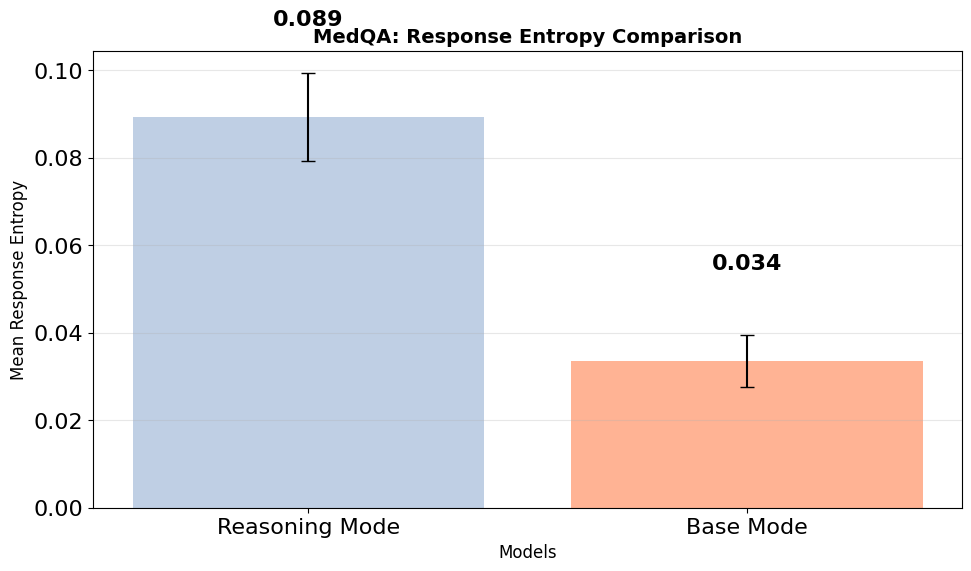

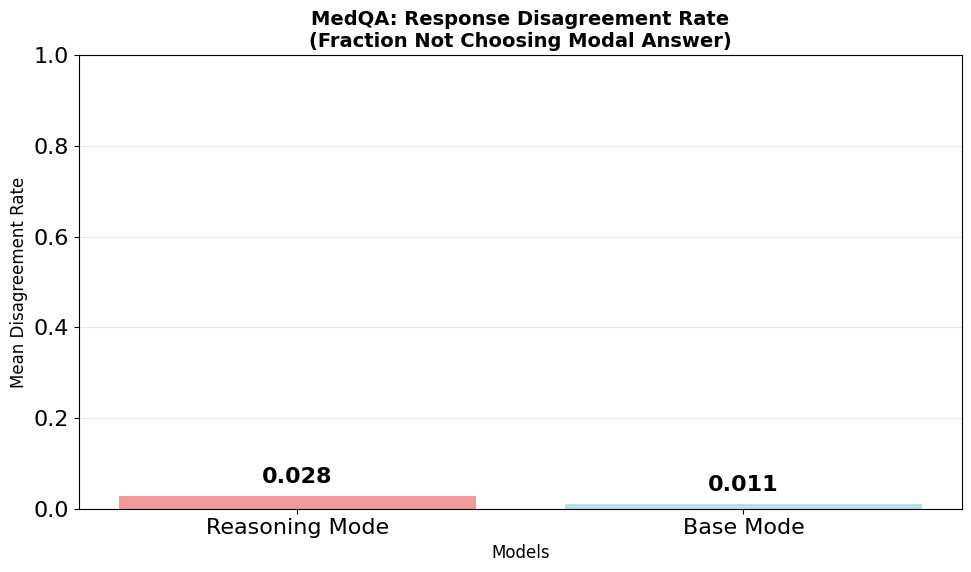

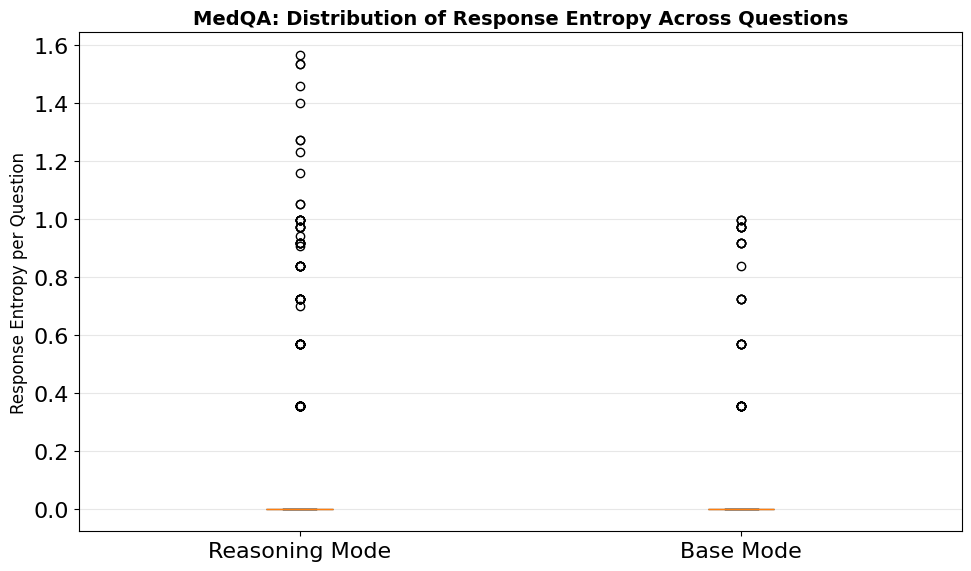

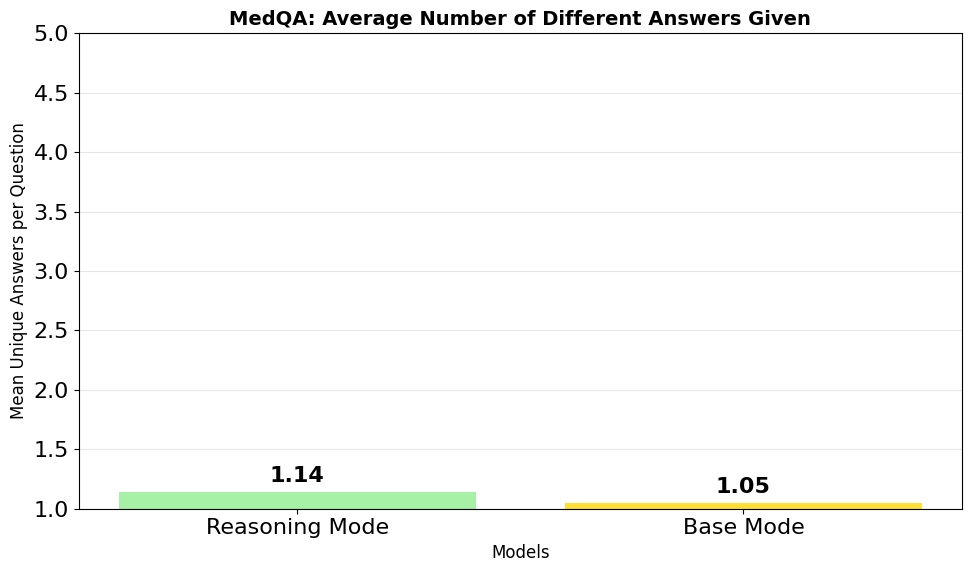


MEDQA ENTROPY ANALYSIS RESULTS
Reasoning Mode:
  Mean Entropy: 0.0893 (±0.2670)
  Mean Disagreement Rate: 0.0282
  Mean Unique Answers: 1.14
  Questions: 700

Base Mode:
  Mean Entropy: 0.0336 (±0.1572)
  Mean Disagreement Rate: 0.0110
  Mean Unique Answers: 1.05
  Questions: 700

Entropy Summary:
  reasoning_model: 0.0893 ±0.2670
  base_model: 0.0336 ±0.1572

STATISTICAL SIGNIFICANCE TESTING: RESPONSE ENTROPY
Significance level (α): 0.05
Number of models being compared: 2

COMPARISON: Reasoning Mode vs Base Mode

📊 Paired t-test on Question-Level Entropy
--------------------------------------------------------------------------------
Common questions: 695
Reasoning Mode:
  Mean entropy: 0.0889 ± 0.2668
Base Mode:
  Mean entropy: 0.0338 ± 0.1578
Difference: -0.0551

Paired t-test results:
  t-statistic: -5.1674
  p-value: 0.000000
  ✓ SIGNIFICANT difference (p < 0.05)
  → Reasoning Mode has significantly HIGHER entropy than Base Mode
     (More variable/inconsistent responses)


In [71]:
print("Calculating entropy...")

entropy_results = calculate_medqa_entropy(all_model_data, EVAL_PATH)

print("Entropy Summary:")
for m, s in entropy_results.items():
    print(f"  {m}: {s['mean_entropy']:.4f} ±{s['std_entropy']:.4f}")

# Run statistical significance tests
if len(entropy_results) >= 2:
    compute_entropy_statistical_significance(entropy_results, alpha=0.05)
else:
    print("Need at least 2 models for statistical comparison")

### 7.3 Strategy Analysis

Analyzing strategies...

✅ Reasoning Mode: Found 34493 strategies
⏭️ Base Mode: No strategies found - skipping analysis

📊 Analyzing strategies for 1 model(s) with strategy data...

🔍 Analyzing reasoning strategies for Reasoning Mode...


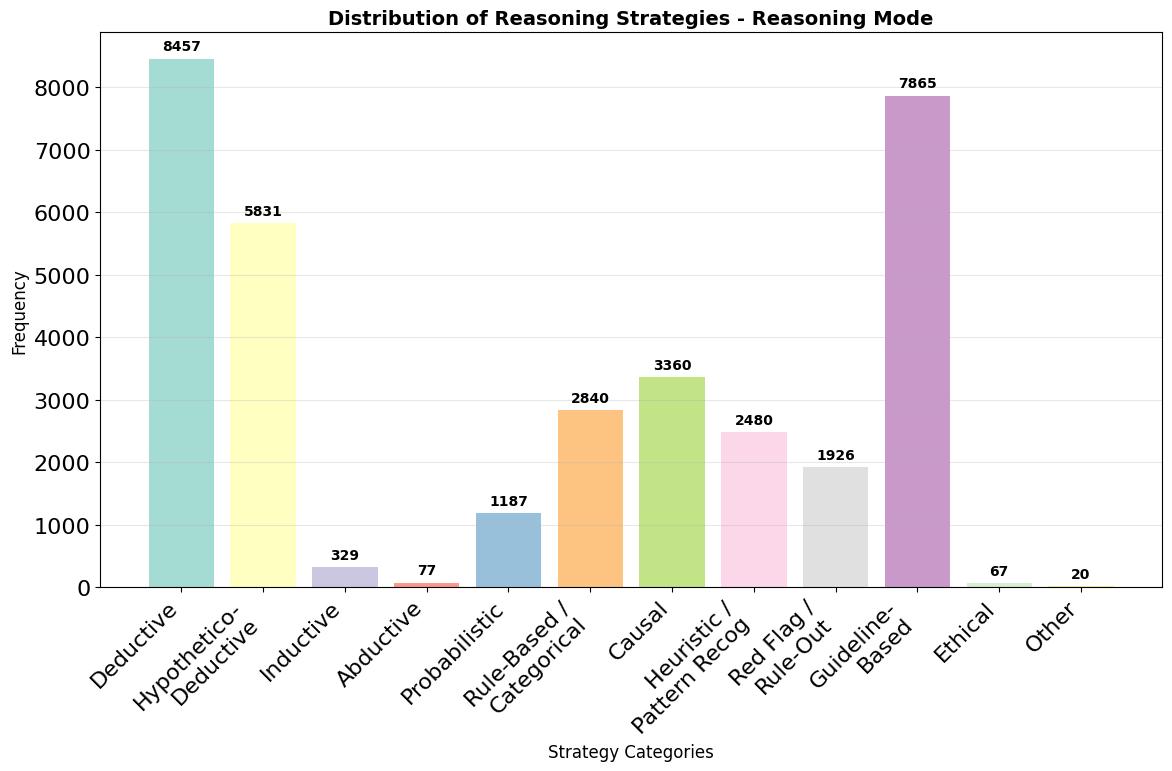

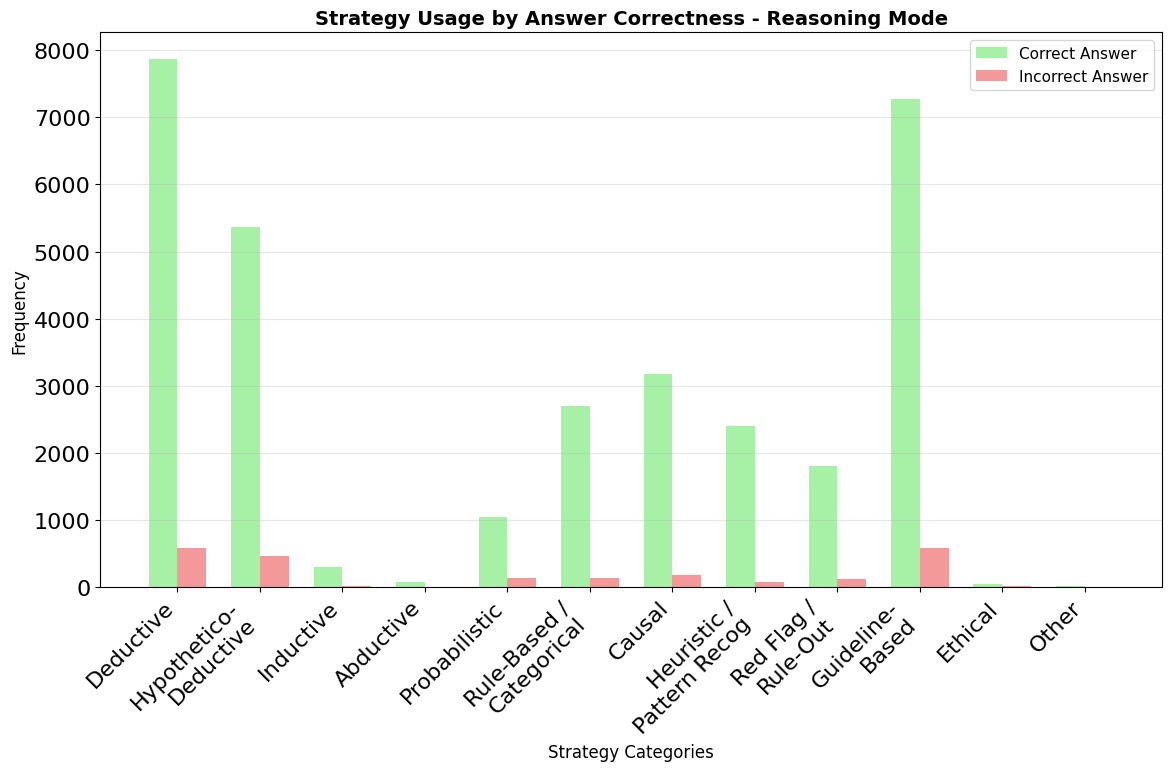

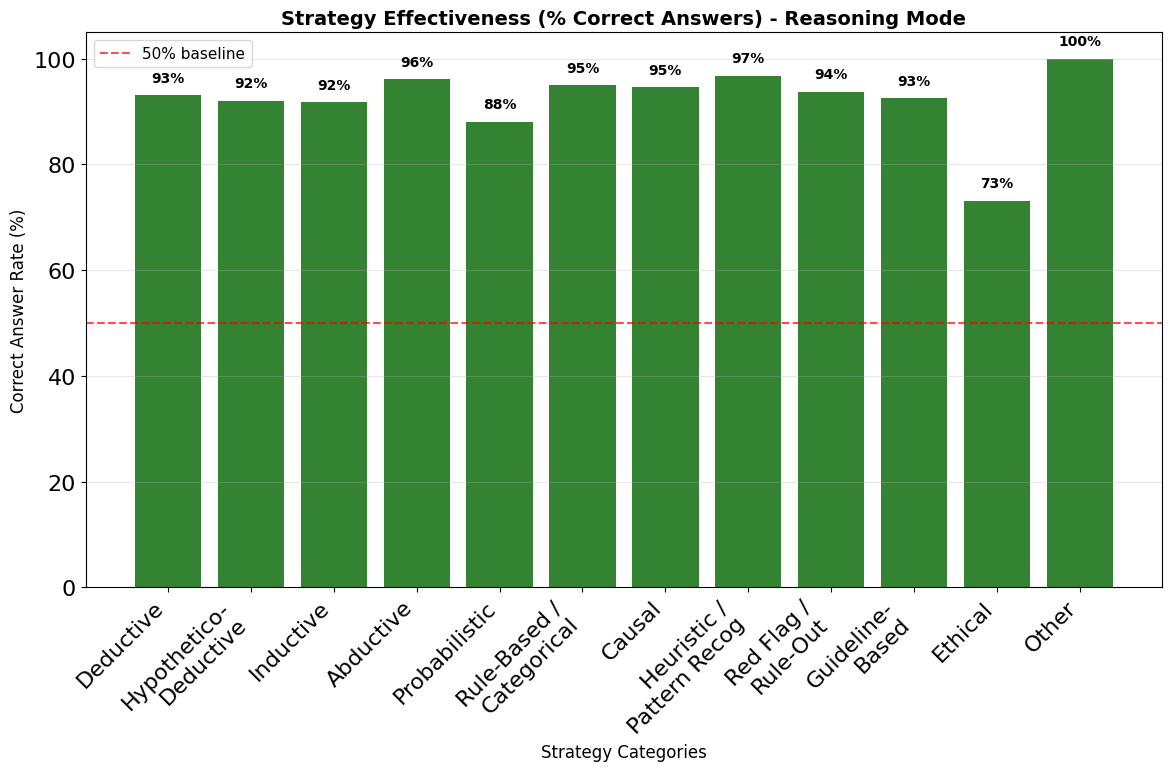

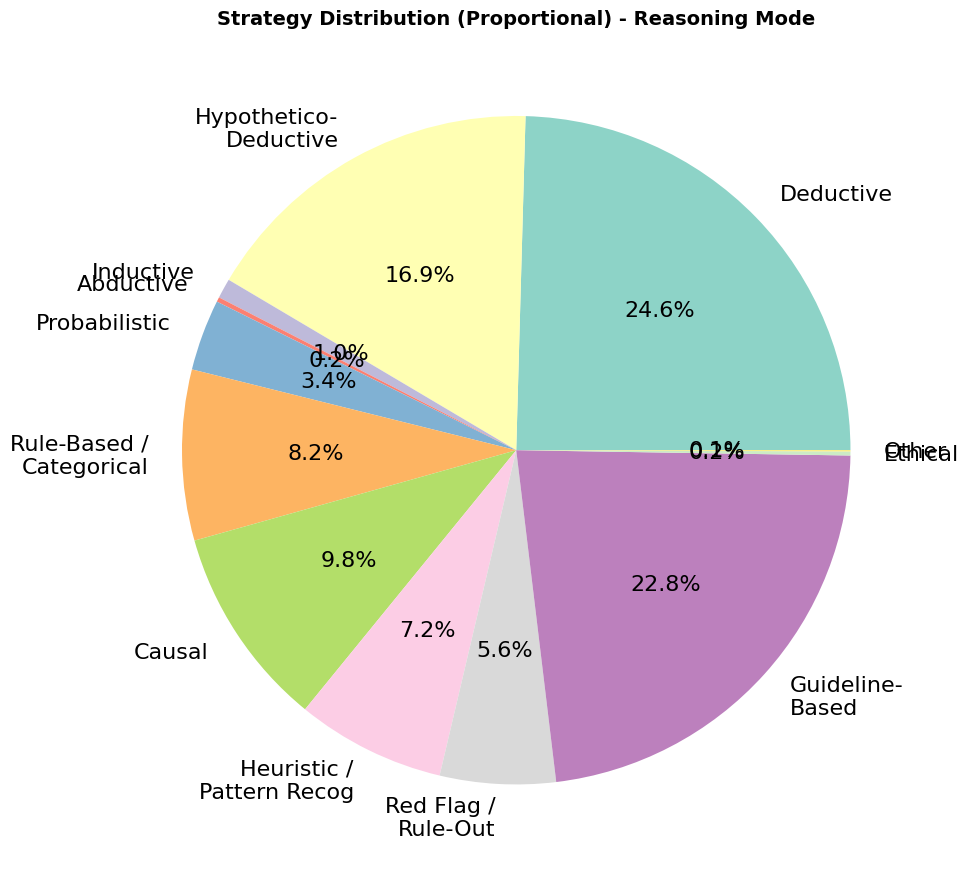


--- Official Category Summary for Reasoning Mode ---
Strategies mapped to official categories: 34473
Strategies categorized as 'other': 20

Official category usage (ranked by frequency):
   1. Deductive Reasoning: 8457 uses, 93.1% success
   2. Guideline-Based Reasoning: 7865 uses, 92.5% success
   3. Hypothetico-Deductive Reasoning: 5831 uses, 92.1% success
   4. Causal Reasoning: 3360 uses, 94.6% success
   5. Rule-Based / Categorical / Deterministic Reasoning: 2840 uses, 95.0% success
   6. Heuristic / Pattern Recognition (Fast Thinking): 2480 uses, 96.7% success
   7. Red Flag / Rule-Out Reasoning: 1926 uses, 93.8% success
   8. Probabilistic Reasoning: 1187 uses, 88.1% success
   9. Inductive Reasoning: 329 uses, 91.8% success
  10. Abductive Reasoning: 77 uses, 96.1% success
  11. Ethical Reasoning: 67 uses, 73.1% success
  12. Patient-Centered Risk-Benefit Analysis: 54 uses, 90.7% success
  13. other: 20 uses, 100.0% success
✓ Complete


In [77]:
print("Analyzing strategies...\n")

analyze_strategies_official_categories_medqa(all_model_data, EVAL_PATH)

print("✓ Complete")

---
## Complete!

**Outputs:**
- `plots/` - All visualizations
- `metrics_*.jsonl` - Per-question data
- `false_questions_*.jsonl` - Incorrectly answered questions
- `errors_*.jsonl` - Processing errors

**Statistical Tests:**
- MedQA scores: Unpaired t-test on random sampling distribution
- Entropy: Paired t-test on question-level entropy values

**Customization:**
- Edit `MODEL_LABELS` dict in the configuration section (cell c5) to customize model display names
- Adjust `REASON` flag to enable/disable strategy extraction
- Configure paths in `BASE_PATH`, `RESPONSE_DIR`, and `EVAL_PATH`